

# Team
- Tom Perez le Tiec (Leader)
- Maille Jérémy



# DELIVERABLE 2


In this project, we use the DEAP library to implement a genetic algorithm (GA), an adaptive heuristic search algorithm that is part of evolutionary algorithms. Inspired by natural selection, genetic algorithms simulate the "survival of the fittest" to solve a given problem. Each generation is a population of individuals, with each individual representing a potential solution within the search space. Each individual is represented as a string of characters, integers, floats, or bits, corresponding to a specific point in the search space.

To initialize the population, we create a collection of individuals, where each individual represents a potential delivery solution. Individuals are structured as chromosomes, consisting of several genes. Here, each gene corresponds to a delivery location or client, with markers (-1) used to separate different truck routes.

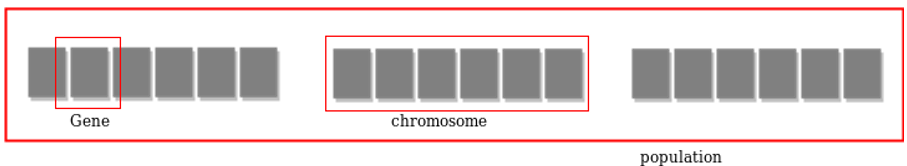

The clients' and depot's addresses are extracted from an Excel file, then converted into geographic coordinates using Geopy. The time windows for each client are also transformed into minutes to simplify calculations. Each address is then matched to the nearest node on a road network graph of Barcelona, allowing us to build time and distance matrices for optimizing travel routes between each location.

To generate the initial individuals, a function is used to create random permutations of clients without including the depot, ensuring a diverse set of routes in the initial population. This approach provides a varied base of potential solutions, ready for further optimization by the genetic algorithm.

The fitness evaluation measures each individual's ability to solve the problem, with the algorithm seeking those with the lowest scores, as the goal is to minimize travel time. In our program, the evaluate function calculates each individual's score based on the total travel time and penalties for missed clients or exceeding the maximum number of clients per truck.

The selection process is based on fitness scores, with the best-performing individuals selected to mate and produce a new generation by combining parent chromosomes. Since population size remains fixed, less fit individuals are replaced by newcomers, allowing each generation to progressively improve the quality of proposed solutions.

Initially, we applied this genetic algorithm to the VRPTW problem, where the goal was to find the most efficient routes for a set of vehicles to deliver goods to clients, each with a specific time window. By optimizing routes to minimize total distance or travel time while respecting time windows and vehicle capacities, we achieved satisfactory results.

We then extended the problem by introducing a constraint on the number of trucks (K-trucks), with each vehicle subject to a 2D capacity constraint. In this version of VRPTW, each vehicle starts and ends its route at the depot and has specific capacity limits. The objective remains to minimize total distance or travel time. However, the addition of this constraint did not produce results as optimal as in the first version of the problem, as the fixed number of trucks introduced inefficiencies in managing routes and time windows. The model struggled to find optimal solutions for full coverage, suggesting that further adjustments are necessary to improve the performance of this constrained version of VRPTW.

## Full implementation of the VRP with time windows

## Data structure
In the provided code, well-defined data structures are implemented to support the Vehicle Routing Problem with Time Windows (VRPTW). A Pandas DataFrame is used to load and manage client and depot data, including addresses and time windows. Lists and tuples store the geographical coordinates, time windows, and nearest graph nodes for each location. Graph structures are employed using the osmnx library to model the city's road network, and adjacency matrices are created to hold the travel times and distances between nodes. Additionally, DEAP's evolutionary algorithm framework uses customized fitness classes and individual representations to define and evaluate potential solutions. These data structures collectively enable efficient data handling and problem-solving.

In [ ]:
import pandas as pd
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import folium
import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
import time as sleep_module
import re
from deap import base, creator, tools, algorithms
import random
from datetime import datetime, timedelta, time as datetime_time

# Load client data from an Excel file
file_path = 'clients_depot_barcelone.xlsx'
df = pd.read_excel(file_path)

def time_to_minutes(t):
    """Convert various time formats (datetime.time, int, float, or HH:MM string) to minutes since midnight.
    Returns the time in minutes as an integer. Returns 0 if format is unrecognized."""
    if isinstance(t, datetime_time):
        return t.hour * 60 + t.minute
    elif isinstance(t, (int, float)):
        return int(t)
    elif isinstance(t, str):
        try:
            match = re.match(r"(\d{1,2}):(\d{2})", t)
            if match:
                hours, minutes = map(int, match.groups())
                return hours * 60 + minutes
            return int(t)
        except ValueError:
            print(f"Unrecognized time format: {t}. Defaulting to 0 minutes.")
            return 0
    return 0

depot_address = df['Adresse'].iloc[0]
client_addresses = df['Adresse'].iloc[1:].tolist()

# Get client time windows, excluding depot; add depot time window separately
time_windows = [(time_to_minutes(df['Ouverture'].iloc[i]), time_to_minutes(df['Fermeture'].iloc[i])) for i in range(1, len(df))]
depot_time_window = (0, 1440)

# Initialize geocoder and get coordinates for depot and clients
geolocator = Nominatim(user_agent="vrp_app")
locations = []
addresses = [depot_address] + client_addresses
for address in addresses:
    try:
        location = geolocator.geocode(address, timeout=10)
        if location:
            locations.append((location.latitude, location.longitude))
        else:
            print(f"Address not found: {address}")
            locations.append((None, None))
    except Exception as e:
        print(f"Error with address {address}: {e}")
        locations.append((None, None))
    sleep_module.sleep(1)

# Filter valid addresses
locations = [coords for coords in locations if coords != (None, None)]
depot_location = locations[0]
client_locations = locations[1:]

# Load Barcelona graph
graph = ox.graph_from_place('Barcelona, Spain', network_type='drive')
graph = graph.to_undirected().subgraph(max(nx.connected_components(graph.to_undirected()), key=len)).copy()

def get_nearest_nodes(graph, locations):
    """Find the nearest nodes in the graph to each location.
    Returns a list of node IDs corresponding to each input location."""
    return [ox.distance.nearest_nodes(graph, loc[1], loc[0]) for loc in locations]

nodes = get_nearest_nodes(graph, client_locations)
depot_node = get_nearest_nodes(graph, [depot_location])[0]
nodes_with_depot = [depot_node] + nodes

def parse_speed(speed_str):
    """Parse speed from string format or use default if unavailable.
    Returns speed as a float."""
    if isinstance(speed_str, list):
        speed_str = speed_str[0]
    if isinstance(speed_str, str):
        match = re.match(r"(\d+)", speed_str)
        if match:
            return float(match.group(1))
    return 50.0

def calculate_neighbor_times(graph):
    """Calculate travel time between neighboring nodes in the graph based on distance and speed.
    Returns a dictionary with edge travel times."""
    neighbor_times = {}
    for u, v, data in graph.edges(data=True):
        distance = data.get('length', 0) / 1000
        speed = parse_speed(data.get('maxspeed', '50'))
        travel_time = (distance / speed) * 60
        neighbor_times[(u, v)] = travel_time
    return neighbor_times

neighbor_times = calculate_neighbor_times(graph)

def calculate_time_matrix(graph, nodes):
    """Compute travel time and distance matrices between all pairs of specified nodes.
    Returns two matrices: time_matrix with travel times, and distance_matrix with distances."""
    time_matrix = []
    distance_matrix = []
    for node1 in nodes:
        time_row = []
        distance_row = []
        for node2 in nodes:
            if node1 == node2:
                time_row.append(0)
                distance_row.append(0)
            else:
                try:
                    path = nx.shortest_path(graph, node1, node2, weight='length')
                    total_time = 0
                    total_distance = 0
                    for u, v in zip(path[:-1], path[1:]):
                        edge_data = graph.get_edge_data(u, v)
                        edge = edge_data[0] if isinstance(edge_data, dict) else edge_data
                        distance = edge.get('length', 0) / 1000
                        speed = parse_speed(edge.get('maxspeed', '50'))
                        travel_time = distance / speed * 60
                        total_time += travel_time
                        total_distance += distance
                    time_row.append(total_time)
                    distance_row.append(total_distance)
                except nx.NetworkXNoPath:
                    time_row.append(float('inf'))
                    distance_row.append(float('inf'))
        time_matrix.append(time_row)
        distance_matrix.append(distance_row)
    return time_matrix, distance_matrix

time_matrix, distance_matrix = calculate_time_matrix(graph, nodes_with_depot)

# Convert all time windows to minutes
time_windows = [
    (time_to_minutes(open_time), time_to_minutes(close_time))
    for open_time, close_time in time_windows
]

# DEAP VRPTW Implementation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, len(nodes)), len(nodes) - 1)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

population = toolbox.population(n=100)
for ind in population:
    assert len(ind) == len(nodes) - 1, "Individual has incorrect length!"

def evaluate(individual):
    """Evaluate an individual's route, penalizing violations of time windows.
    Returns the route's total travel time with penalties."""
    route = [0] + individual + [0]
    total_time = 0
    last_departure = 0
    penalty = 0

    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        travel_time = time_matrix[from_node][to_node]
        arrival_time = last_departure + travel_time
        window_open, window_close = time_windows[to_node]

        if arrival_time < window_open:
            waiting_time = window_open - arrival_time
            arrival_time = window_open
            penalty += waiting_time
        elif arrival_time > window_close:
            penalty += (arrival_time - window_close) * 10  # Penalty for arriving late

        total_time += travel_time
        last_departure = arrival_time

    return total_time + penalty,

toolbox.register("evaluate", evaluate)

def custom_cxOrdered(ind1, ind2):
    """Perform ordered crossover with length checks for VRP individuals.
    Returns two offspring individuals with mixed parent genes."""
    size = len(ind1)
    if len(ind1) != len(ind2):
        raise ValueError("Individuals must be of the same length")

    start, end = sorted(random.sample(range(size), 2))

    child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2)
    child1[start:end + 1] = ind2[start:end + 1]

    pos = end + 1
    for gene in ind1:
        if gene not in child1[start:end + 1]:
            if pos >= size:
                pos = 0
            while start <= pos <= end:
                pos += 1
                if pos >= size:
                    pos = 0
            child1[pos] = gene
            pos += 1

    child2[start:end + 1] = ind1[start:end + 1]
    pos = end + 1
    for gene in ind2:
        if gene not in child2[start:end + 1]:
            if pos >= size:
                pos = 0
            while start <= pos <= end:
                pos += 1
                if pos >= size:
                    pos = 0
            child2[pos] = gene
            pos += 1

    return child1, child2


# Register the new custom crossover in the DEAP toolbox
toolbox.register("mate", custom_cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with validation after mating
population_size = 100
generations = 50

# Evaluation of each generation and selection
for gen in range(generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)

    # Evaluate only valid individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Filter offspring that violate time windows
    valid_offspring = [ind for ind in offspring if ind.fitness.values[0] < float('inf')]

    # If no valid offspring, penalize heavily to encourage mutations towards valid solutions
    if not valid_offspring:
        for ind in offspring:
            ind.fitness.values = (float('inf'),)
        valid_offspring = population  # Reuse current population as backup

    population = toolbox.select(valid_offspring + population, k=population_size)

# Select the best solution after the loop
best_individual = tools.selBest(population, k=1)[0]
best_route = [0] + best_individual + [0]

# Display route details
total_time = 0
print("\nOptimized route details with time windows:")
for i in range(len(best_route) - 1):
    from_node = best_route[i]
    to_node = best_route[i + 1]
    travel_time = time_matrix[from_node][to_node]
    print(f"From {from_node} to {to_node}: Travel time = {travel_time:.2f} min")
    total_time += travel_time

print(f"\nTotal optimized time: {total_time:.2f} minutes")

# Create a map with the optimized route
map_center = depot_location
carte = folium.Map(location=map_center, zoom_start=13)

# Depot marker
folium.Marker(depot_location, popup="Depot", icon=folium.Icon(color="black")).add_to(carte)

def minutes_to_time(minutes):
    """Convert minutes to HH:MM format for readability. Returns a formatted time string."""
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f"{hours:02}:{mins:02}"

def plot_routes_with_time_details(solution, graph, nodes, time_windows, time_matrix):
    """Plot the route on a map with markers at each client location, displaying time details.
    Adds the complete route and each client’s time window, arrival, and departure times."""
    route_coords = []
    cumulative_time = 480  # Start cumulative time at 08:00 (480 minutes)

    # Plot the route
    for i in range(len(solution) - 1):
        try:
            path = nx.shortest_path(graph, nodes[solution[i]], nodes[solution[i + 1]], weight='length')
            coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in path]
            route_coords.extend(coords)
        except nx.NetworkXNoPath:
            print(f"No path between {solution[i]} and {solution[i + 1]}")
            continue
    folium.PolyLine(route_coords, color="blue", weight=2.5, opacity=0.8).add_to(carte)

    # Initial marker for the depot (starting point)
    depot_location = (graph.nodes[nodes[solution[0]]]['y'], graph.nodes[nodes[solution[0]]]['x'])
    depot_departure_time = minutes_to_time(cumulative_time)
    folium.Marker(
        depot_location,
        popup=f"Depot (Client 0)<br>Departure Time: {depot_departure_time}",
        icon=folium.Icon(color="black", icon="info-sign")
    ).add_to(carte)

    print(f"Depot (Client 0): Location {depot_location}")
    print(f"  Departure Time: {depot_departure_time}\n")

    # Place markers for each client with time details
    for idx in range(1, len(solution) - 1):
        location = (graph.nodes[nodes[solution[idx]]]['y'], graph.nodes[nodes[solution[idx]]]['x'])
        time_window = time_windows[solution[idx]]
        travel_time = time_matrix[solution[idx - 1]][solution[idx]]
        arrival_time = cumulative_time + travel_time
        opening_time, closing_time = time_window
        waiting_time = max(0, opening_time - arrival_time)
        departure_time = arrival_time + waiting_time
        arrival_time_str = minutes_to_time(arrival_time)
        departure_time_str = minutes_to_time(departure_time)
        waiting_time_str = f"{int(waiting_time)} min" if waiting_time > 0 else "No waiting"
        cumulative_time = departure_time

        popup_text = (
            f"Client {solution[idx]}<br>"
            f"Time Window: {minutes_to_time(opening_time)} - {minutes_to_time(closing_time)}<br>"
            f"Arrival Time: {arrival_time_str}<br>"
            f"Departure Time: {departure_time_str}<br>"
            f"Waiting Time: {waiting_time_str}"
        )

        print(f"Client {solution[idx]}: Location {location}")
        print(f"  Time Window: {minutes_to_time(opening_time)} - {minutes_to_time(closing_time)}")
        print(f"  Arrival Time: {arrival_time_str}")
        print(f"  Departure Time: {departure_time_str}")
        print(f"  Waiting Time: {waiting_time_str}\n")

        folium.Marker(
            location,
            popup=popup_text,
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(carte)

    last_client_id = solution[-2]
    final_travel_time = time_matrix[last_client_id][solution[-1]]
    depot_arrival_time = cumulative_time + final_travel_time
    depot_arrival_time_str = minutes_to_time(depot_arrival_time)

    print(f"Return to Depot (Client 0): Location {depot_location}")
    print(f"  Arrival Time: {depot_arrival_time_str}\n")

    folium.Marker(
        depot_location,
        popup=f"Depot (Client 0)<br>Arrival Time: {depot_arrival_time_str}",
        icon=folium.Icon(color="black", icon="info-sign")
    ).add_to(carte)

graph_route = best_route

plot_routes_with_time_details(graph_route, graph, nodes, time_windows, time_matrix)
carte.save("map_vrptw_barcelona.html")
print("VRPTW map with client locations and time details saved as 'map_vrptw_barcelona.html'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.17.0 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 5.26.1 which is incompatible.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is inco

FileNotFoundError: [Errno 2] No such file or directory: 'test2\\clients_depot_barcelone.xlsx'

## Code to generate random Adress in an Excel file

In [ ]:
import random
import time
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def get_random_addresses_in_barcelona(n):
    """
    Generates a list of random addresses in Barcelona.

    Parameters:
    n (int): The number of addresses to generate.

    Returns:
    list: A list of formatted address strings located in Barcelona, Spain.
    """
    geolocator = Nominatim(user_agent="adresse_generator_app_v1")
    lat_min, lat_max = 41.291, 41.443
    lon_min, lon_max = 2.070, 2.230
    addresses = []
    attempts = 0

    while len(addresses) < n and attempts < 300:
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)

        try:
            location = geolocator.reverse((lat, lon), language="fr", exactly_one=True, addressdetails=True, timeout=10)
            if location:
                address_parts = location.raw.get('address', {})
                street = address_parts.get('road', '')
                number = address_parts.get('house_number', '')
                city = address_parts.get('city', '')
                postcode = address_parts.get('postcode', '')

                if street and number:
                    formatted_address = f"{street}, {number}, {postcode} Barcelona, Spain"
                    addresses.append(formatted_address)

        except GeocoderTimedOut:
            print(f"Timeout error for coordinates ({lat}, {lon}), retrying...")
        except Exception as e:
            print(f"Geocoding error for coordinates ({lat}, {lon}): {e}")

        time.sleep(1)
        attempts += 1

    if len(addresses) < n:
        print(f"Warning: Less than {n} valid addresses found after {attempts} attempts.")

    return addresses

def generate_random_delivery_windows(n):
    """
    Generates random delivery windows for each address.

    Parameters:
    n (int): The number of delivery windows to generate.

    Returns:
    list: A list of tuples containing opening and closing times for each address.
    """
    windows = [("08:00", "18:00")]

    for _ in range(1, n):
        opening_hour = random.randint(8, 15)
        opening_minute = random.choice([0, 15, 30, 45])
        closing_hour = opening_hour + 3
        closing_minute = random.choice([0, 15, 30, 45])

        if closing_hour > 17 or (closing_hour == 17 and closing_minute > 30):
            closing_hour = 17
            closing_minute = 30

        opening_time = f"{opening_hour:02}:{opening_minute:02}"
        closing_time = f"{closing_hour:02}:{closing_minute:02}"
        windows.append((opening_time, closing_time))

    return windows

def create_excel_with_addresses(n):
    """
    Generates an Excel file containing random addresses in Barcelona and their delivery windows.

    Parameters:
    n (int): The number of addresses (including depot) to generate.

    Returns:
    None
    """
    random_addresses = get_random_addresses_in_barcelona(n)
    delivery_windows = generate_random_delivery_windows(n)

    data = {
        "Adresse": random_addresses,
        "Ouverture": [window[0] for window in delivery_windows],
        "Fermeture": [window[1] for window in delivery_windows]
    }

    df = pd.DataFrame(data)
    df.to_excel("test2/clients_depot_barcelone.xlsx", index=False)
    print("Data has been saved to 'clients_depot_barcelone.xlsx'.")

create_excel_with_addresses(10)


## Explanation of how the algorithm works

The program reads client locations and time windows from an Excel file. It uses geolocation services to obtain coordinates, which are then mapped to nodes on a road network for Barcelona.

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
import time as sleep_module

# Load data from Excel
file_path = 'clients_depot_barcelone.xlsx'
df = pd.read_excel(file_path)
depot_address = df['Adresse'].iloc[0]
client_addresses = df['Adresse'].iloc[1:].tolist()

# Geocode to get coordinates
geolocator = Nominatim(user_agent="vrp_app")
locations = []
addresses = [depot_address] + client_addresses
for address in addresses:
    try:
        location = geolocator.geocode(address, timeout=10)
        locations.append((location.latitude, location.longitude) if location else (None, None))
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        locations.append((None, None))
    sleep_module.sleep(1)

# Remove invalid coordinates
locations = [coords for coords in locations if coords != (None, None)]


Using OpenStreetMap and NetworkX, the program builds a graph of the road network, calculates travel times between nodes, and creates matrices for distance and time between each client and depot node.

In [ ]:
import osmnx as ox
import networkx as nx
import re

# Build road network for Barcelona
depot_location = locations[0]
graph = ox.graph_from_place('Barcelona, Spain', network_type='drive')
graph = graph.to_undirected().subgraph(max(nx.connected_components(graph.to_undirected()), key=len)).copy()

# Define helper functions
def parse_speed(speed_str):
    if isinstance(speed_str, list):
        speed_str = speed_str[0]
    if isinstance(speed_str, str):
        match = re.match(r"(\d+)", speed_str)
        if match:
            return float(match.group(1))
    return 50.0  # Default speed

# Calculate time and distance matrices
def calculate_time_matrix(graph, nodes):
    time_matrix = []
    distance_matrix = []
    for node1 in nodes:
        time_row = []
        distance_row = []
        for node2 in nodes:
            if node1 == node2:
                time_row.append(0)
                distance_row.append(0)
            else:
                try:
                    path = nx.shortest_path(graph, node1, node2, weight='length')
                    total_time, total_distance = 0, 0
                    for u, v in zip(path[:-1], path[1:]):
                        edge = graph.get_edge_data(u, v)[0] if isinstance(graph.get_edge_data(u, v), dict) else graph.get_edge_data(u, v)
                        distance = edge.get('length', 0) / 1000
                        speed = parse_speed(edge.get('maxspeed', '50'))
                        travel_time = distance / speed * 60
                        total_time += travel_time
                        total_distance += distance
                    time_row.append(total_time)
                    distance_row.append(total_distance)
                except nx.NetworkXNoPath:
                    time_row.append(float('inf'))
                    distance_row.append(float('inf'))
        time_matrix.append(time_row)
        distance_matrix.append(distance_row)
    return time_matrix, distance_matrix

# Get nearest nodes and calculate matrices
def get_nearest_nodes(graph, locations):
    return [ox.distance.nearest_nodes(graph, loc[1], loc[0]) for loc in locations]

nodes = get_nearest_nodes(graph, locations)
time_matrix, distance_matrix = calculate_time_matrix(graph, nodes)


With the DEAP library, a genetic algorithm iterates over various routes, evaluating each based on travel time and penalties for missed time windows. It then applies crossover and mutation operations to improve the route over multiple generations.

In [ ]:
from deap import base, creator, tools, algorithms
import random
from datetime import time as datetime_time

# Fitness function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define evaluation function
def evaluate(individual):
    route = [0] + individual + [0]
    total_time = 0
    last_departure = 0
    penalty = 0

    for i in range(len(route) - 1):
        from_node, to_node = route[i], route[i + 1]
        travel_time = time_matrix[from_node][to_node]
        arrival_time = last_departure + travel_time
        window_open, window_close = time_windows[to_node]

        if arrival_time < window_open:
            waiting_time = window_open - arrival_time
            arrival_time = window_open
            penalty += waiting_time
        elif arrival_time > window_close:
            penalty += (arrival_time - window_close) * 10  # Penalty for being late

        total_time += travel_time
        last_departure = arrival_time

    return total_time + penalty,

# Set up genetic algorithm
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, len(nodes)), len(nodes) - 1)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run genetic algorithm
population = toolbox.population(n=100)
final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50, verbose=True)


The final optimized route, with detailed timing for each stop, is displayed on a Folium map.

In [ ]:
import folium

# Function to generate map with the optimized route
def generate_map(route, locations, time_windows):
    route_map = folium.Map(location=locations[0], zoom_start=13)
    for idx, location in enumerate(locations):
        folium.Marker(location=location, popup=f"Location {idx}").add_to(route_map)

    for i in range(len(route) - 1):
        folium.PolyLine([locations[route[i]], locations[route[i + 1]]], color="blue").add_to(route_map)

    route_map.save("map_vrptw_barcelona.html")

# Display optimized route on the map
best_individual = tools.selBest(final_population, 1)[0]
optimized_route = [0] + best_individual + [0]
generate_map(optimized_route, locations, time_windows)


The main graphical representation produced is a map, which provides a visual overview of the optimized route and delivery stops, including:
- Depot and Client Markers: Each location is marked on the map with popups showing arrival, waiting, and departure times. The clients are red and the depot is black.
- Route Path: The blue line connects the depot and client locations, representing the vehicle’s route.
- Time Window Compliance: Popups and markers show arrival times, waiting times if any, and whether penalties were incurred for late arrivals.

### Exemple of result

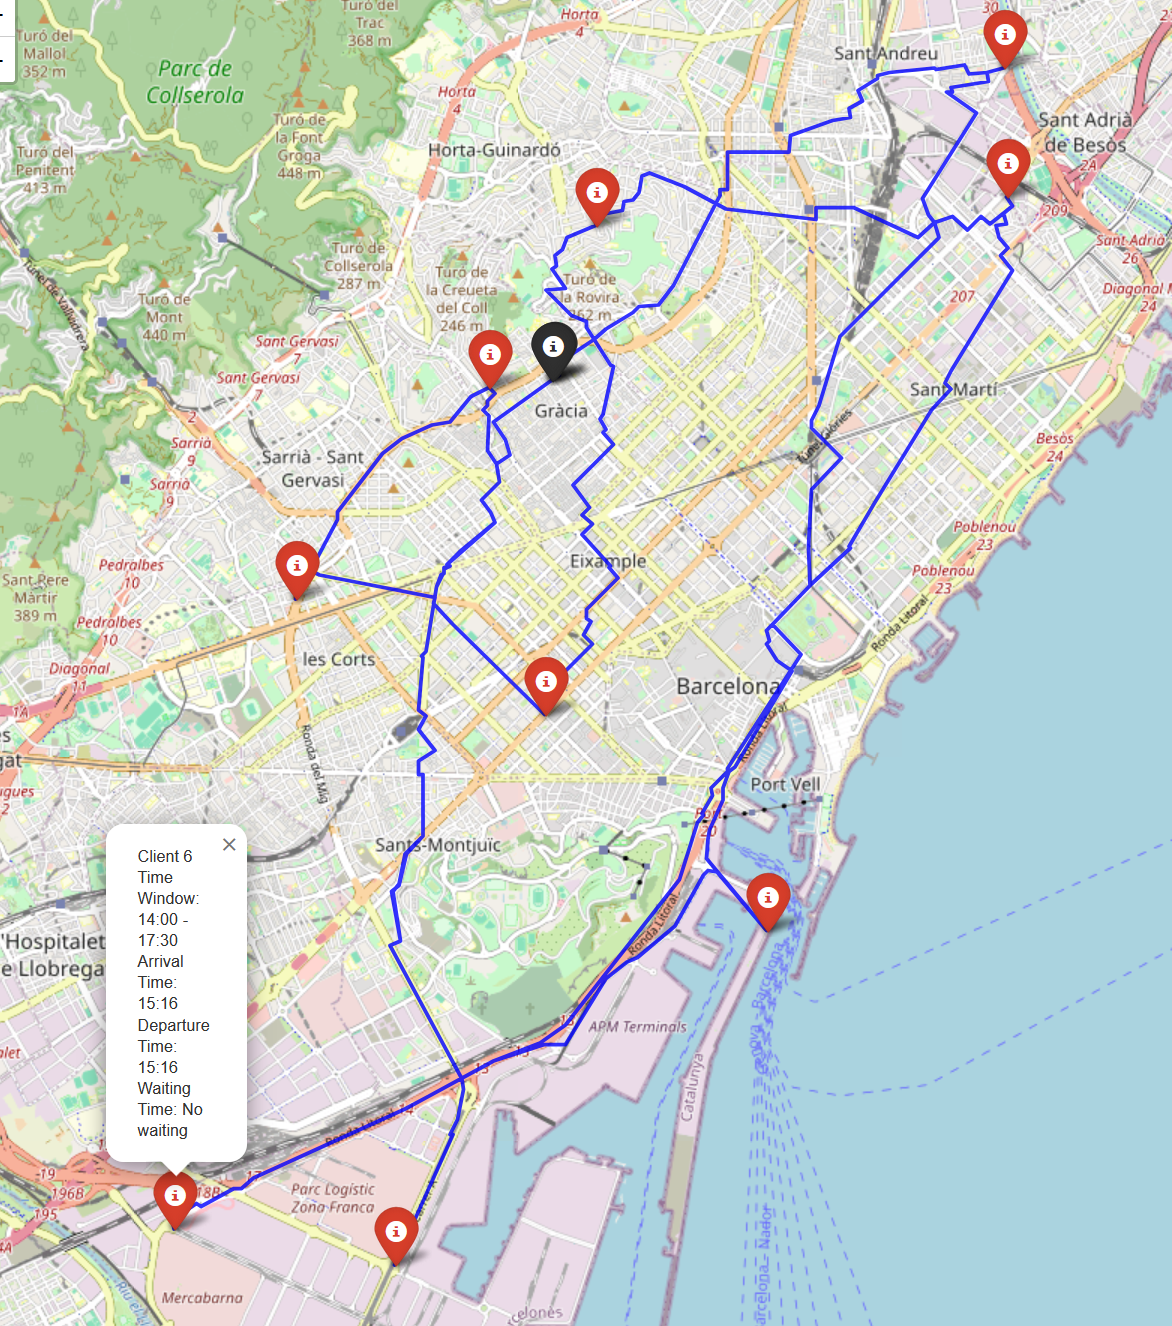

## DELIVERABLE 2 (Attempt with k trucks as an additional constraints)

In [ ]:
import pandas as pd
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import folium
import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
import time as sleep_module
import re
from deap import base, creator, tools, algorithms
import random
from datetime import datetime, timedelta, time as datetime_time
import matplotlib.colors as mcolors
import math
import tkinter as tk
from tkinter import messagebox, Label
import webbrowser
from sklearn.cluster import KMeans
from adress_generator import create_excel_with_addresses

MAP_FILE = "map_vrptw_barcelona_2.html"

def start_vrp_program():
    """Launches the VRP program, initializes settings, and loads client data."""
    try:
        num_trucks = int(num_trucks_entry.get())
        root.destroy()
        loading_window = tk.Tk()
        loading_window.title("Loading...")
        loading_label = Label(loading_window, text="Calculating VRP solution, please wait...")
        loading_label.pack(padx=20, pady=20)
        loading_window.update()
        file_path = 'clients_depot_barcelone.xlsx'
        df = pd.read_excel(file_path)
        print("Columns in df:", df.columns)
        min_generations = 12
        max_generations = 100
        generations = max(max_generations, min_generations)
        depot_address = df['Adresse'].iloc[0]
        client_addresses = df['Adresse'].iloc[1:].tolist()
        time_windows = [(df['Ouverture'].iloc[i], df['Fermeture'].iloc[i]) for i in range(1, len(df))]
        time_windows.insert(0, (0, 1440))
        geolocator = Nominatim(user_agent="vrp_app")
        locations = []
        addresses = [depot_address] + client_addresses
        for address in addresses:
            try:
                location = geolocator.geocode(address, timeout=10)
                if location:
                    locations.append((location.latitude, location.longitude))
                else:
                    print(f"Adresse non trouvÃ©e: {address}")
                    locations.append((None, None))
            except Exception as e:
                print(f"Erreur pour l'adresse {address}: {e}")
                locations.append((None, None))
            sleep_module.sleep(1)
        locations = [coords for coords in locations if coords != (None, None)]
        depot_location = locations[0]
        graph = ox.graph_from_place('Barcelona, Spain', network_type='drive')
        graph = graph.to_undirected().subgraph(max(nx.connected_components(graph.to_undirected()), key=len)).copy()

        def get_nearest_nodes(graph, locations):
            """Finds the nearest nodes in the graph to the specified locations.
            Returns a list of nearest node IDs for each location."""
            return [ox.distance.nearest_nodes(graph, loc[1], loc[0]) for loc in locations]

        nodes = get_nearest_nodes(graph, locations)

        def parse_speed(speed_str):
            """Parses speed information from string to a numeric value.
            Returns speed as float or default value if not found."""
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            if isinstance(speed_str, str):
                match = re.match(r"(\d+)", speed_str)
                if match:
                    return float(match.group(1))
            return 50.0

        def calculate_neighbor_times(graph):
            """Calculates travel times between direct neighbors based on speed and distance.
            Returns a dictionary with travel times for each edge."""
            neighbor_times = {}
            for u, v, data in graph.edges(data=True):
                distance = data.get('length', 0) / 1000
                speed = parse_speed(data.get('maxspeed', '50'))
                travel_time = (distance / speed) * 60
                neighbor_times[(u, v)] = travel_time
            return neighbor_times

        neighbor_times = calculate_neighbor_times(graph)

        def calculate_time_matrix(graph, nodes):
            """Calculates travel time and distance matrices for the specified nodes.
            Returns matrices containing travel times and distances between each pair of nodes."""
            time_matrix = []
            distance_matrix = []
            for node1 in nodes:
                time_row = []
                distance_row = []
                for node2 in nodes:
                    if node1 == node2:
                        time_row.append(0)
                        distance_row.append(0)
                    else:
                        try:
                            path = nx.shortest_path(graph, node1, node2, weight='length')
                            total_time = 0
                            total_distance = 0
                            for u, v in zip(path[:-1], path[1:]):
                                edge_data = graph.get_edge_data(u, v)
                                edge = edge_data[0] if isinstance(edge_data, dict) else edge_data
                                distance = edge.get('length', 0) / 1000
                                speed = parse_speed(edge.get('maxspeed', '50'))
                                travel_time = distance / speed * 60
                                total_time += travel_time
                                total_distance += distance
                            time_row.append(total_time)
                            distance_row.append(total_distance)
                        except nx.NetworkXNoPath:
                            time_row.append(float('inf'))
                            distance_row.append(float('inf'))
                time_matrix.append(time_row)
                distance_matrix.append(distance_row)
            return time_matrix, distance_matrix

        time_matrix, distance_matrix = calculate_time_matrix(graph, nodes)

        def time_to_minutes(t):
            """Convert a datetime.time object to minutes since midnight.
            Returns the time in minutes as an integer."""
            return t.hour * 60 + t.minute

        def convert_to_minutes(time_str):
            """Convert a time string in 'HH:MM' format to minutes since midnight.
            Returns the time in minutes as an integer."""
            try:
                time_obj = datetime.strptime(time_str, '%H:%M')
                return time_obj.hour * 60 + time_obj.minute
            except ValueError:
                raise ValueError(f"Invalid time format: '{time_str}'")

        time_windows = [
            (convert_to_minutes(df['Ouverture'].iloc[i]), convert_to_minutes(df['Fermeture'].iloc[i]))
            for i in range(len(df))
        ]

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("indices", random.sample, range(1, len(nodes)), len(nodes) - 1)

        def init_individual_with_trucks():
            """Creates an initial individual solution that includes all clients, with separators between trucks.
            Returns a DEAP Individual with clients and separators."""
            individual = random.sample(range(1, len(nodes)), len(nodes) - 1)
            separators = [-1] * (num_trucks - 1)
            for i in range(num_trucks - 1):
                pos = random.randint(1, len(individual))
                individual.insert(pos, -1)
            return creator.Individual(individual + separators)

        toolbox.register("individual", init_individual_with_trucks)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def init_individual_time_window_clusters():
            """Initializes an individual by clustering clients based on time windows and locations.
            Returns a DEAP Individual arranged with clustered clients and separators."""
            client_data = [(locations[i][0], locations[i][1], time_windows[i][0]) for i in range(1, len(nodes))]
            kmeans = KMeans(n_clusters=num_trucks).fit(client_data)
            clusters = kmeans.labels_
            individual = []
            for cluster_id in range(num_trucks):
                clients_in_cluster = [i + 1 for i, c in enumerate(clusters) if c == cluster_id]
                individual.extend(clients_in_cluster + [-1])
            return creator.Individual(individual[:-1])

        toolbox.register("individual", init_individual_time_window_clusters)

        def evaluate_time_window_balanced(individual):
            """Evaluates a route solution considering time windows, penalties, and truck constraints.
            Returns a tuple with total time and penalties for the evaluated individual."""
            routes = []
            route = [0]
            served_clients = set()
            visited_clients = set()
            total_time = 0
            total_penalty = 0
            for gene in individual:
                if gene == -1:
                    route.append(0)
                    if len(route) > 2:
                        routes.append(route)
                    route = [0]
                else:
                    route.append(gene)
                    served_clients.add(gene)
                    if gene in visited_clients:
                        total_penalty += 5000
                    else:
                        visited_clients.add(gene)
            route.append(0)
            if len(route) > 2:
                routes.append(route)

            unused_trucks_penalty = 3000 * (num_trucks - len(routes))
            total_penalty += unused_trucks_penalty

            all_clients = set(range(1, len(nodes)))
            missed_clients = all_clients - served_clients
            total_penalty += 1000 * len(missed_clients)

            max_clients_per_truck = len(nodes) // num_trucks
            for route in routes:
                if len(route) - 2 > max_clients_per_truck:
                    total_penalty += 2000
                last_departure = 0
                for i in range(len(route) - 1):
                    from_node = route[i]
                    to_node = route[i + 1]
                    travel_time = time_matrix[from_node][to_node]
                    arrival_time = last_departure + travel_time
                    window_open, window_close = time_windows[to_node]
                    if arrival_time < window_open:
                        waiting_time = window_open - arrival_time
                        arrival_time = window_open
                        total_penalty += waiting_time
                    elif arrival_time > window_close:
                        total_penalty += (arrival_time - window_close) * 1000
                    total_time += travel_time
                    last_departure = arrival_time
            return total_time + total_penalty,

        toolbox.register("evaluate", evaluate_time_window_balanced)

        def custom_cxOrdered_with_time_window(ind1, ind2):
            """Performs an ordered crossover with time window constraints.
            Returns two offspring individuals with valid truck separation and client sequences."""
            temp1 = [gene for gene in ind1 if gene != -1]
            temp2 = [gene for gene in ind2 if gene != -1]
            start, end = sorted(random.sample(range(len(temp1)), 2))
            child1_genes = temp1[:start] + [gene for gene in temp2[start:end + 1] if gene not in temp1[:start]]
            child1_genes += [gene for gene in temp1[end + 1:] if gene not in child1_genes]
            child2_genes = temp2[:start] + [gene for gene in temp1[start:end + 1] if gene not in temp2[:start]]
            child2_genes += [gene for gene in temp2[end + 1:] if gene not in child2_genes]
            for _ in range(num_trucks - 1):
                pos1 = random.randint(0, len(child1_genes))
                child1_genes.insert(pos1, -1)
                pos2 = random.randint(0, len(child2_genes))
                child2_genes.insert(pos2, -1)
            return creator.Individual(child1_genes), creator.Individual(child2_genes)

        def mutate_with_time_window_constraint(individual):
            """Mutates an individual by shuffling clients within each truck's route.
            Returns a mutated individual that maintains truck separation and route validity."""
            routes = []
            route = []
            for gene in individual:
                if gene == -1:
                    if route:
                        random.shuffle(route)
                        routes.append(route)
                    routes.append([-1])
                    route = []
                else:
                    route.append(gene)
            if route:
                random.shuffle(route)
                routes.append(route)
            mutated_individual = [gene for route in routes for gene in route]
            return creator.Individual(mutated_individual),

        toolbox.register("mate", custom_cxOrdered_with_time_window)
        toolbox.register("mutate", mutate_with_time_window_constraint)

        toolbox.register("select", tools.selTournament, tournsize=3)

        population_size = 100
        population = toolbox.population(n=population_size)

        for gen in range(generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
            for ind in offspring:
                if ind.count(-1) != num_trucks - 1:
                    print(f"Generation {gen}")
                    continue
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            population = toolbox.select(offspring + population, k=population_size)

        best_individual = tools.selBest(population, k=1)[0]
        best_routes = []
        route = [0]
        for gene in best_individual:
            if gene == -1:
                route.append(0)
                best_routes.append(route)
                route = [0]
            else:
                route.append(gene)
        route.append(0)
        best_routes.append(route)

        for truck_idx, route in enumerate(best_routes):
            total_time = 0
            print(f"\nOptimized route details for truck {truck_idx + 1} with time windows:")
            for i in range(len(route) - 1):
                from_node = route[i]
                to_node = route[i + 1]
                travel_time = time_matrix[from_node][to_node]
                print(f"From {from_node} to {to_node}: Travel time = {travel_time:.2f} min")
                total_time += travel_time
            print(f"Total time for truck {truck_idx + 1}: {total_time:.2f} minutes\n")

        map_center = depot_location
        carte = folium.Map(location=map_center, zoom_start=13)

        def minutes_to_time(minutes):
            """Convert minutes since midnight to 'HH:MM' format.
            Returns a formatted string with hours and minutes."""
            hours = int(minutes // 60)
            mins = int(minutes % 60)
            return f"{hours:02}:{mins:02}"

        def get_gradient_colors(start_color, end_color, steps):
            """Generate a list of color values forming a gradient between two specified colors.
            Returns a list of color codes for each step in the gradient."""
            color_map = mcolors.LinearSegmentedColormap.from_list("route_gradient", [start_color, end_color])
            return [mcolors.rgb2hex(color_map(i / (steps - 1))) for i in range(steps)]

        def calculate_bearing(lat1, lon1, lat2, lon2):
            """Calculate the bearing angle from one geographic point to another.
            Returns the angle in degrees between the two points."""
            lat1, lat2 = math.radians(lat1), math.radians(lat2)
            diff_lon = math.radians(lon2 - lon1)
            x = math.sin(diff_lon) * math.cos(lat2)
            y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(diff_lon)
            initial_bearing = math.atan2(x, y)
            return math.degrees(initial_bearing)

        def plot_routes_with_visual_details_for_multiple_trucks(truck_routes, graph, nodes, time_windows, time_matrix):
            """Visualizes each truck's route on a map, adding detailed information about client locations,
            time windows, arrival and departure times, and route segments. Saves the map to an HTML file."""
            colors = ["blue", "green", "purple", "orange", "red", "cyan", "magenta"]
            truck_colors = [colors[i % len(colors)] for i in range(num_trucks)]

            for truck_idx, solution in enumerate(truck_routes):
                cumulative_time = 480
                route_coords = []
                color = truck_colors[truck_idx]

                if len(solution) <= 2:
                    continue

                print(f"\nRoute details for Truck {truck_idx + 1}:")
                for i in range(len(solution) - 1):
                    try:
                        path = nx.shortest_path(graph, nodes[solution[i]], nodes[solution[i + 1]], weight='length')
                        coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in path]
                        route_coords.extend(coords)
                        folium.PolyLine(coords, color=color, weight=2.5, opacity=0.8).add_to(carte)
                        midpoint = coords[len(coords) // 2]
                        folium.Marker(
                            location=midpoint,
                            icon=folium.DivIcon(html=f"<div style='font-size: 16px; color: black;'><b>{i + 1}</b></div>")
                        ).add_to(carte)
                    except nx.NetworkXNoPath:
                        print(f"No path between {solution[i]} and {solution[i + 1]}")
                        continue

                depot_location = (graph.nodes[nodes[solution[0]]]['y'], graph.nodes[nodes[solution[0]]]['x'])
                depot_departure_time = minutes_to_time(cumulative_time)
                folium.Marker(
                    depot_location,
                    popup=f"Depot (Truck {truck_idx + 1})<br>Departure Time: {depot_departure_time}",
                    icon=folium.Icon(color="black", icon="info-sign")
                ).add_to(carte)

                print(f"Depot (Truck {truck_idx + 1}): Location {depot_location}")
                print(f"  Departure Time: {depot_departure_time}\n")

                for idx in range(1, len(solution) - 1):
                    location = (graph.nodes[nodes[solution[idx]]]['y'], graph.nodes[nodes[solution[idx]]]['x'])
                    time_window = time_windows[solution[idx]]
                    travel_time = time_matrix[solution[idx - 1]][solution[idx]]
                    arrival_time = cumulative_time + travel_time
                    opening_time, closing_time = time_window
                    waiting_time = max(0, opening_time - arrival_time)
                    departure_time = arrival_time + waiting_time
                    arrival_time_str = minutes_to_time(arrival_time)
                    departure_time_str = minutes_to_time(departure_time)
                    waiting_time_str = f"{int(waiting_time)} min" if waiting_time > 0 else "No waiting"
                    cumulative_time = departure_time

                    popup_text = (
                        f"Client {solution[idx]}<br>"
                        f"Time Window: {minutes_to_time(opening_time)} - {minutes_to_time(closing_time)}<br>"
                        f"Arrival Time: {arrival_time_str}<br>"
                        f"Departure Time: {departure_time_str}<br>"
                        f"Waiting Time: {waiting_time_str}"
                    )

                    print(f"Client {solution[idx]}: Location {location}")
                    print(f"  Time Window: {minutes_to_time(opening_time)} - {minutes_to_time(closing_time)}")
                    print(f"  Arrival Time: {arrival_time_str}")
                    print(f"  Departure Time: {departure_time_str}")
                    print(f"  Waiting Time: {waiting_time_str}\n")

                    folium.Marker(
                        location,
                        popup=popup_text,
                        icon=folium.Icon(color=color, icon="info-sign")
                    ).add_to(carte)

                last_client_id = solution[-2]
                final_travel_time = time_matrix[last_client_id][solution[-1]]
                depot_arrival_time = cumulative_time + final_travel_time
                depot_arrival_time_str = minutes_to_time(depot_arrival_time)

                print(f"Return to Depot (Truck {truck_idx + 1}): Location {depot_location}")
                print(f"  Arrival Time: {depot_arrival_time_str}\n")

                folium.Marker(
                    depot_location,
                    popup=f"Depot (Truck {truck_idx + 1})<br>Arrival Time: {depot_arrival_time_str}",
                    icon=folium.Icon(color="black", icon="info-sign")
                ).add_to(carte)

        plot_routes_with_visual_details_for_multiple_trucks(best_routes, graph, nodes, time_windows, time_matrix)
        carte.save("map_vrptw_barcelona_2.html")
        print("Program finished.")

        loading_window.destroy()

        webbrowser.open(MAP_FILE)
        print("VRPTW map saved and opened in browser.")

    except ValueError as e:
        messagebox.showerror("Invalid input", "Please enter a valid positive integer for the number of vehicles.")
        return


root = tk.Tk()
root.title("VRP Configuration")
root.geometry("300x150")

label_num_trucks = tk.Label(root, text="Enter the number of trucks:")
label_num_trucks.pack(pady=10)

num_trucks_entry = tk.Entry(root)
num_trucks_entry.pack(pady=5)

start_button = tk.Button(root, text="Start VRP Program", command=start_vrp_program)
start_button.pack(pady=20)

root.mainloop()


We also attempted to ran a program to calculate the optimum number of lorries to use to deliver to all the addresses. Il gère la capacité dans un environnement 2D, afin de déterminer selon le nombre de colis, combien de camions avons-nous besoin.

In [ ]:
!pip install rectpack
from rectpack import newPacker
import pandas as pd


file_path = 'Items.xlsx'
df = pd.read_excel(file_path)


truck_width = 5
truck_length = 15


packer = newPacker()
packer.add_bin(truck_width, truck_length)

# Add items as rectangles with both orientations
for i in range(len(df)):
    width = df.loc[i, 'width']
    length = df.loc[i, 'length']
    packer.add_rect(width, length)
    packer.add_rect(length, width)

packer.pack()


print("Number of trucks needed:", len(packer))


# DELIVERABLE 3

## Experimental Study of quality

Although the program shows improved delivery rates with additional vehicles, the results remain insufficient from a practical standpoint. Even with 4 vehicles, which achieves the highest efficiency, only 63.3% of addresses are reached. Delivering to just over half of the intended locations is far from adequate, especially for a service that likely aims for complete or near-complete coverage. The drop to 60% with a fifth vehicle further highlights potential inefficiencies in the algorithm's design or route planning. This suggests that the current approach may require refinement, such as optimizing route allocation, balancing workload among vehicles, or rethinking the algorithm entirely, to meet the essential goal of serving all addresses.

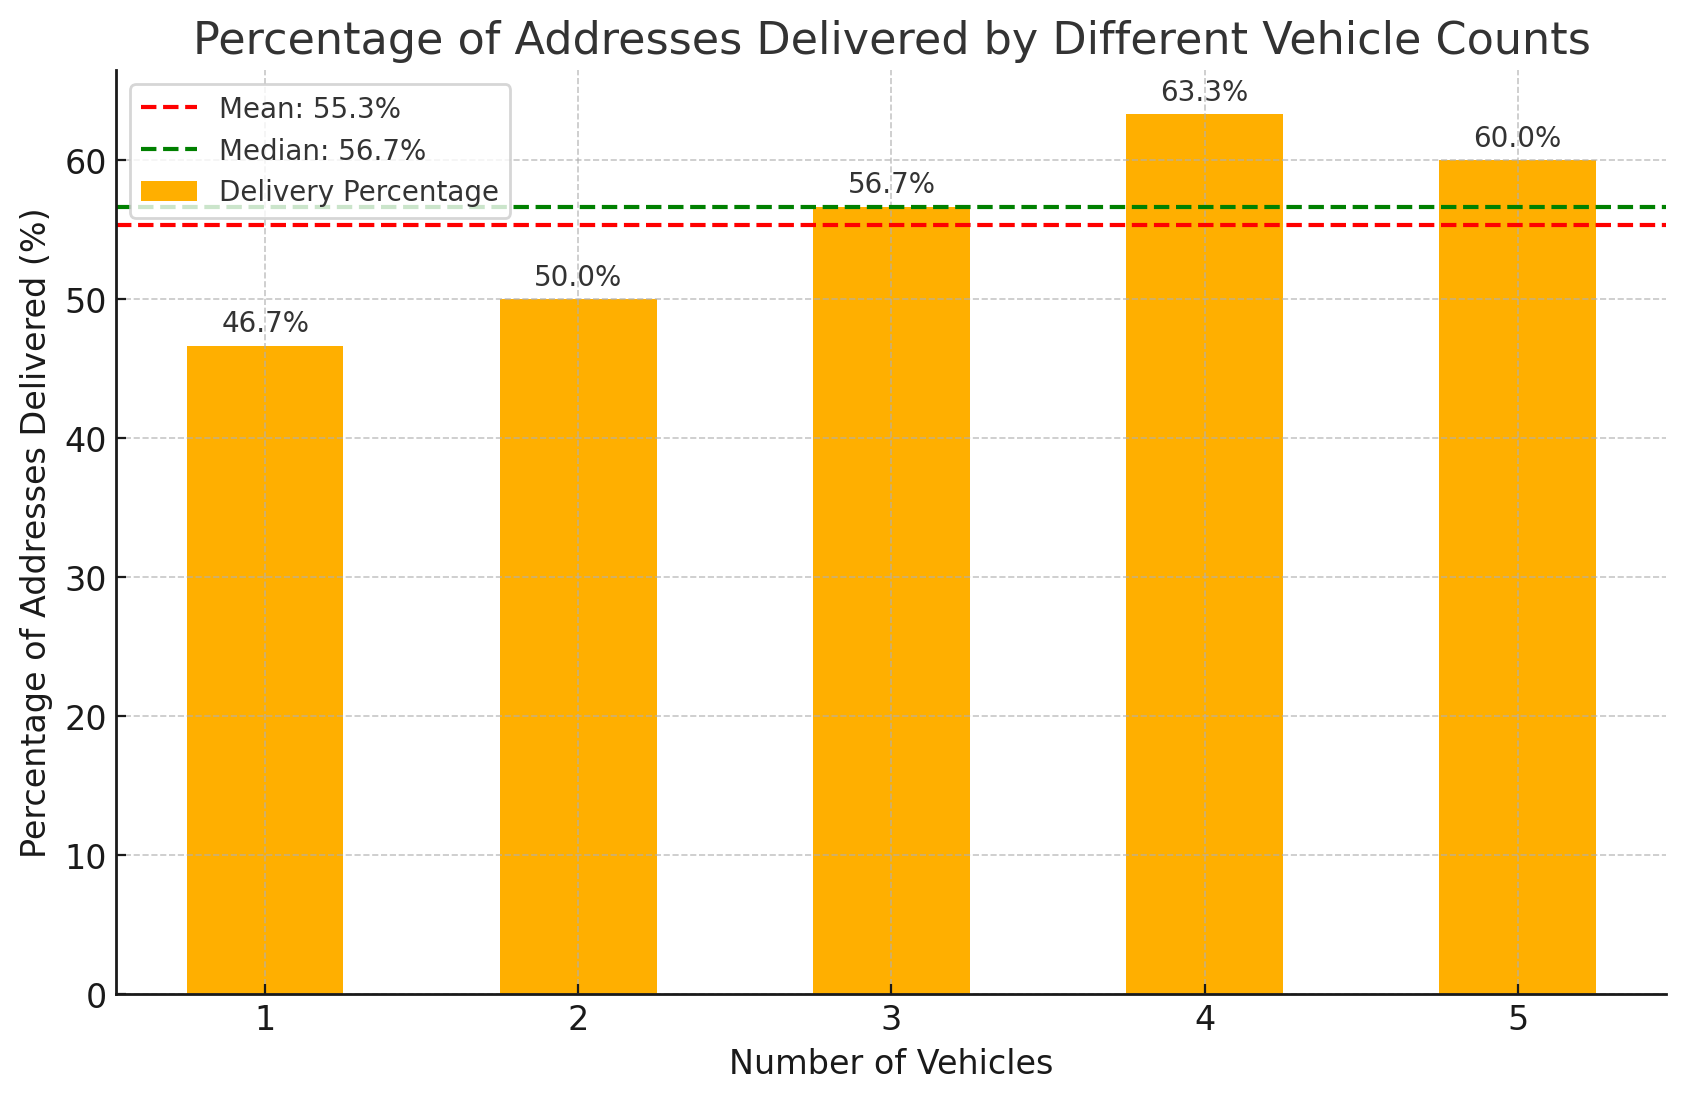

The graph shows that total travel time increases sharply with the number of addresses, reaching nearly 800 minutes for 100 addresses. The mean travel time is 339.5 minutes, while the median is lower at 239.04 minutes, indicating that most routes take less time, but a few significantly longer routes skew the average upwards. This exponential increase in travel time suggests that the program struggles to efficiently handle a high number of addresses. For practical use, such extended travel times are likely unacceptable, indicating a need for improved optimization in route planning or possibly the addition of more resources (like vehicles) to manage the workload better.

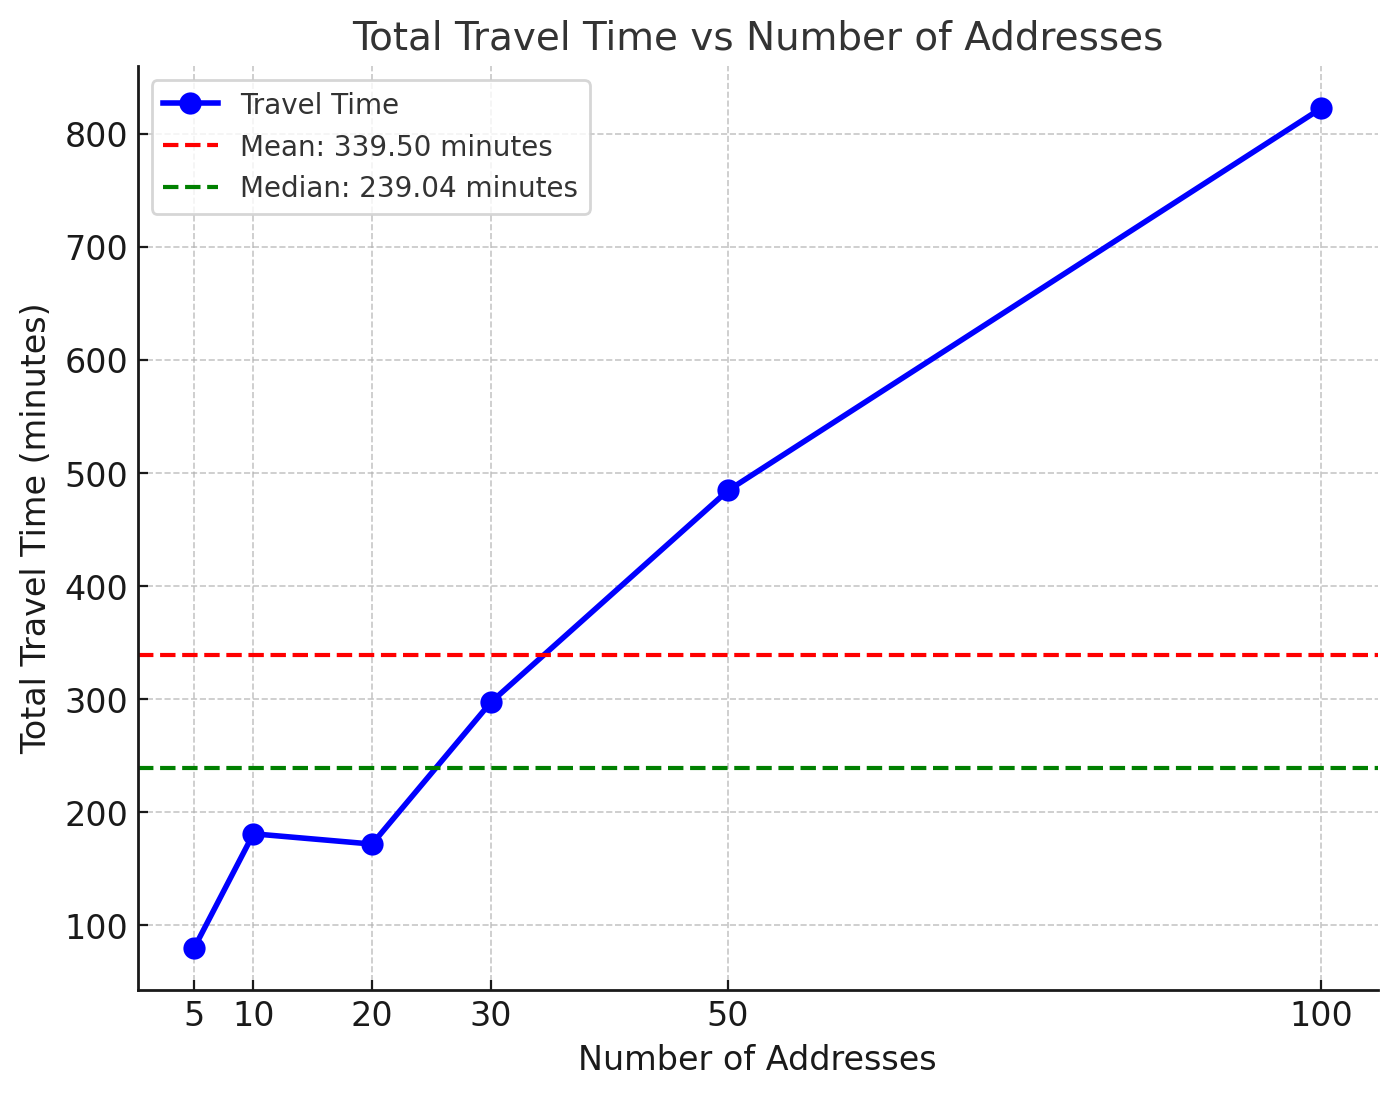

The graph shows a steep rise in deliveries outside the designated time window as the number of addresses increases, reaching 34 out-of-window deliveries at 100 addresses. While the median is low (1.5), the mean is much higher at 9.7, indicating that most routes have few late deliveries, but larger routes face significant timing issues. This suggests that the program struggles to maintain schedule adherence as the number of addresses grows. Improvements in scheduling, route efficiency, or vehicle resources are likely necessary to keep more deliveries within the desired time window.

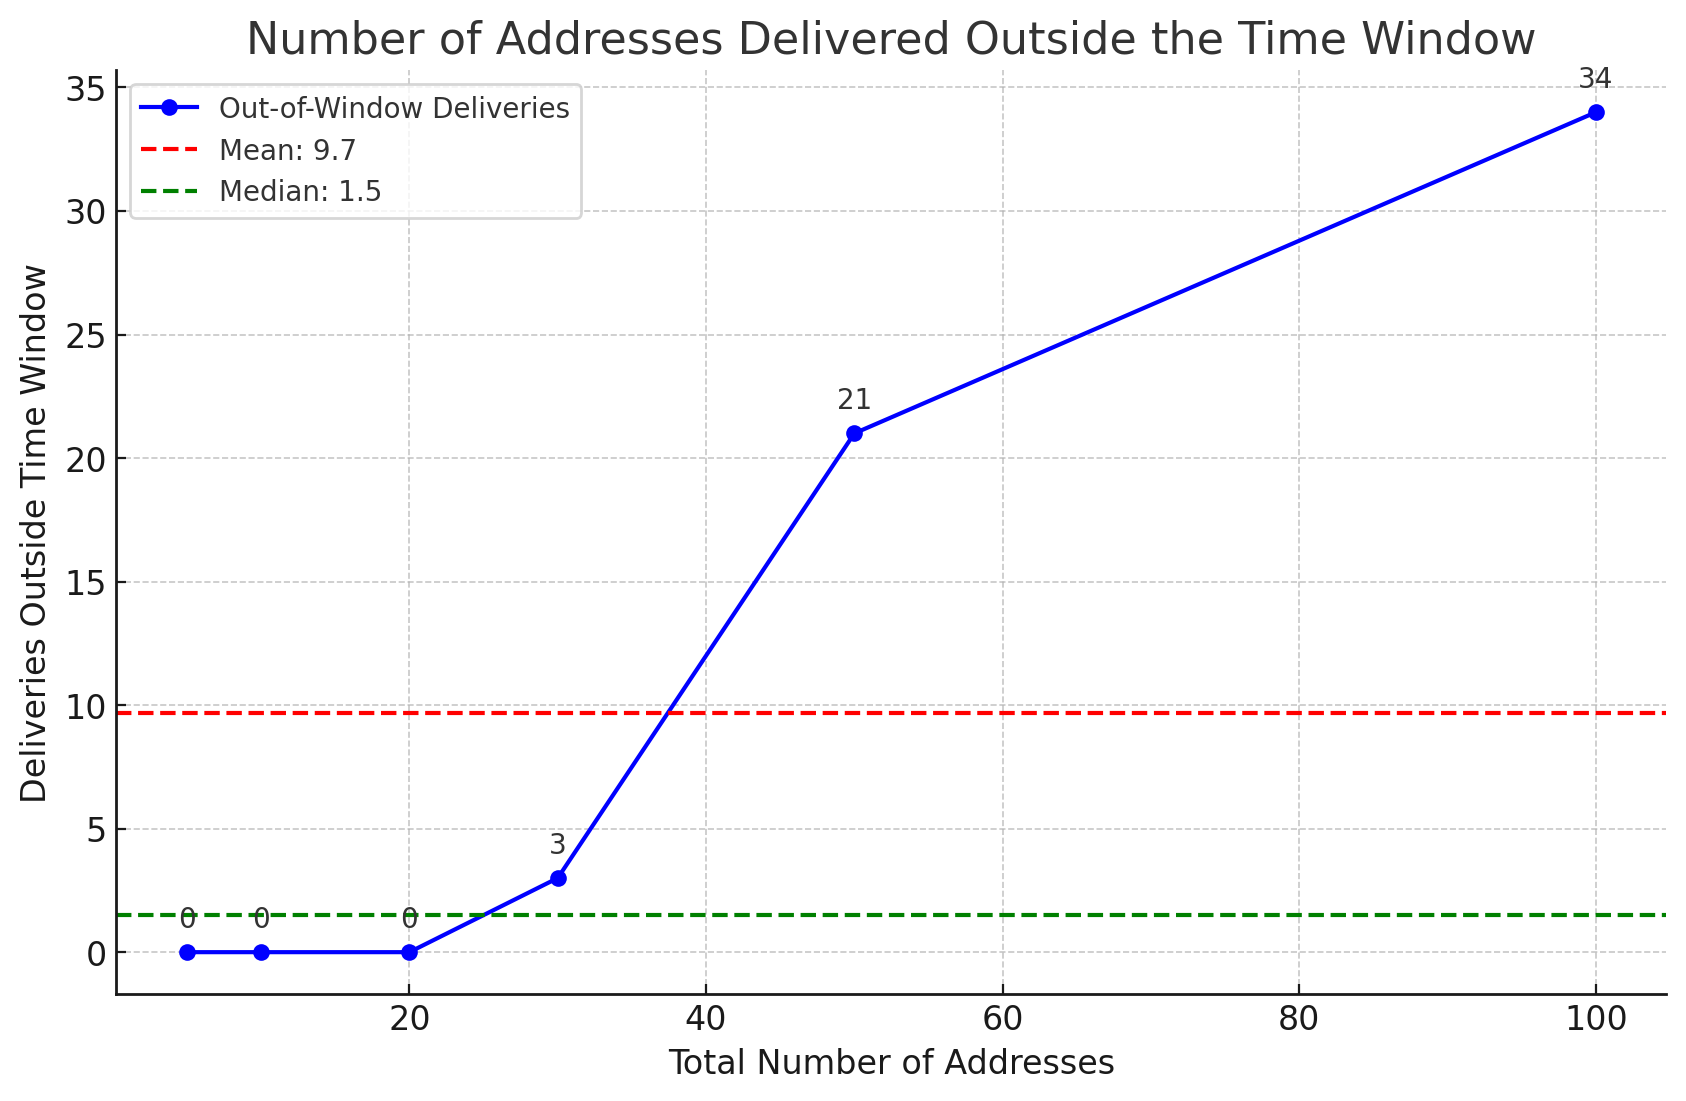

The first set of graphs shows that the Genetic Algorithm (GA) produces longer distances and times compared to the shortest path method, especially as the number of addresses grows. This suggests that while the GA explores alternative paths, it doesn’t achieve the minimal route or time efficiency of the shortest path approach.

The second set of graphs highlights the deviation of the GA from the shortest path. Distance deviation remains mostly stable but peaks at 50 addresses, while time deviation fluctuates more and peaks sharply at both 10 and 50 addresses. This indicates that the GA’s efficiency diminishes as the route complexity increases, particularly at high address counts.

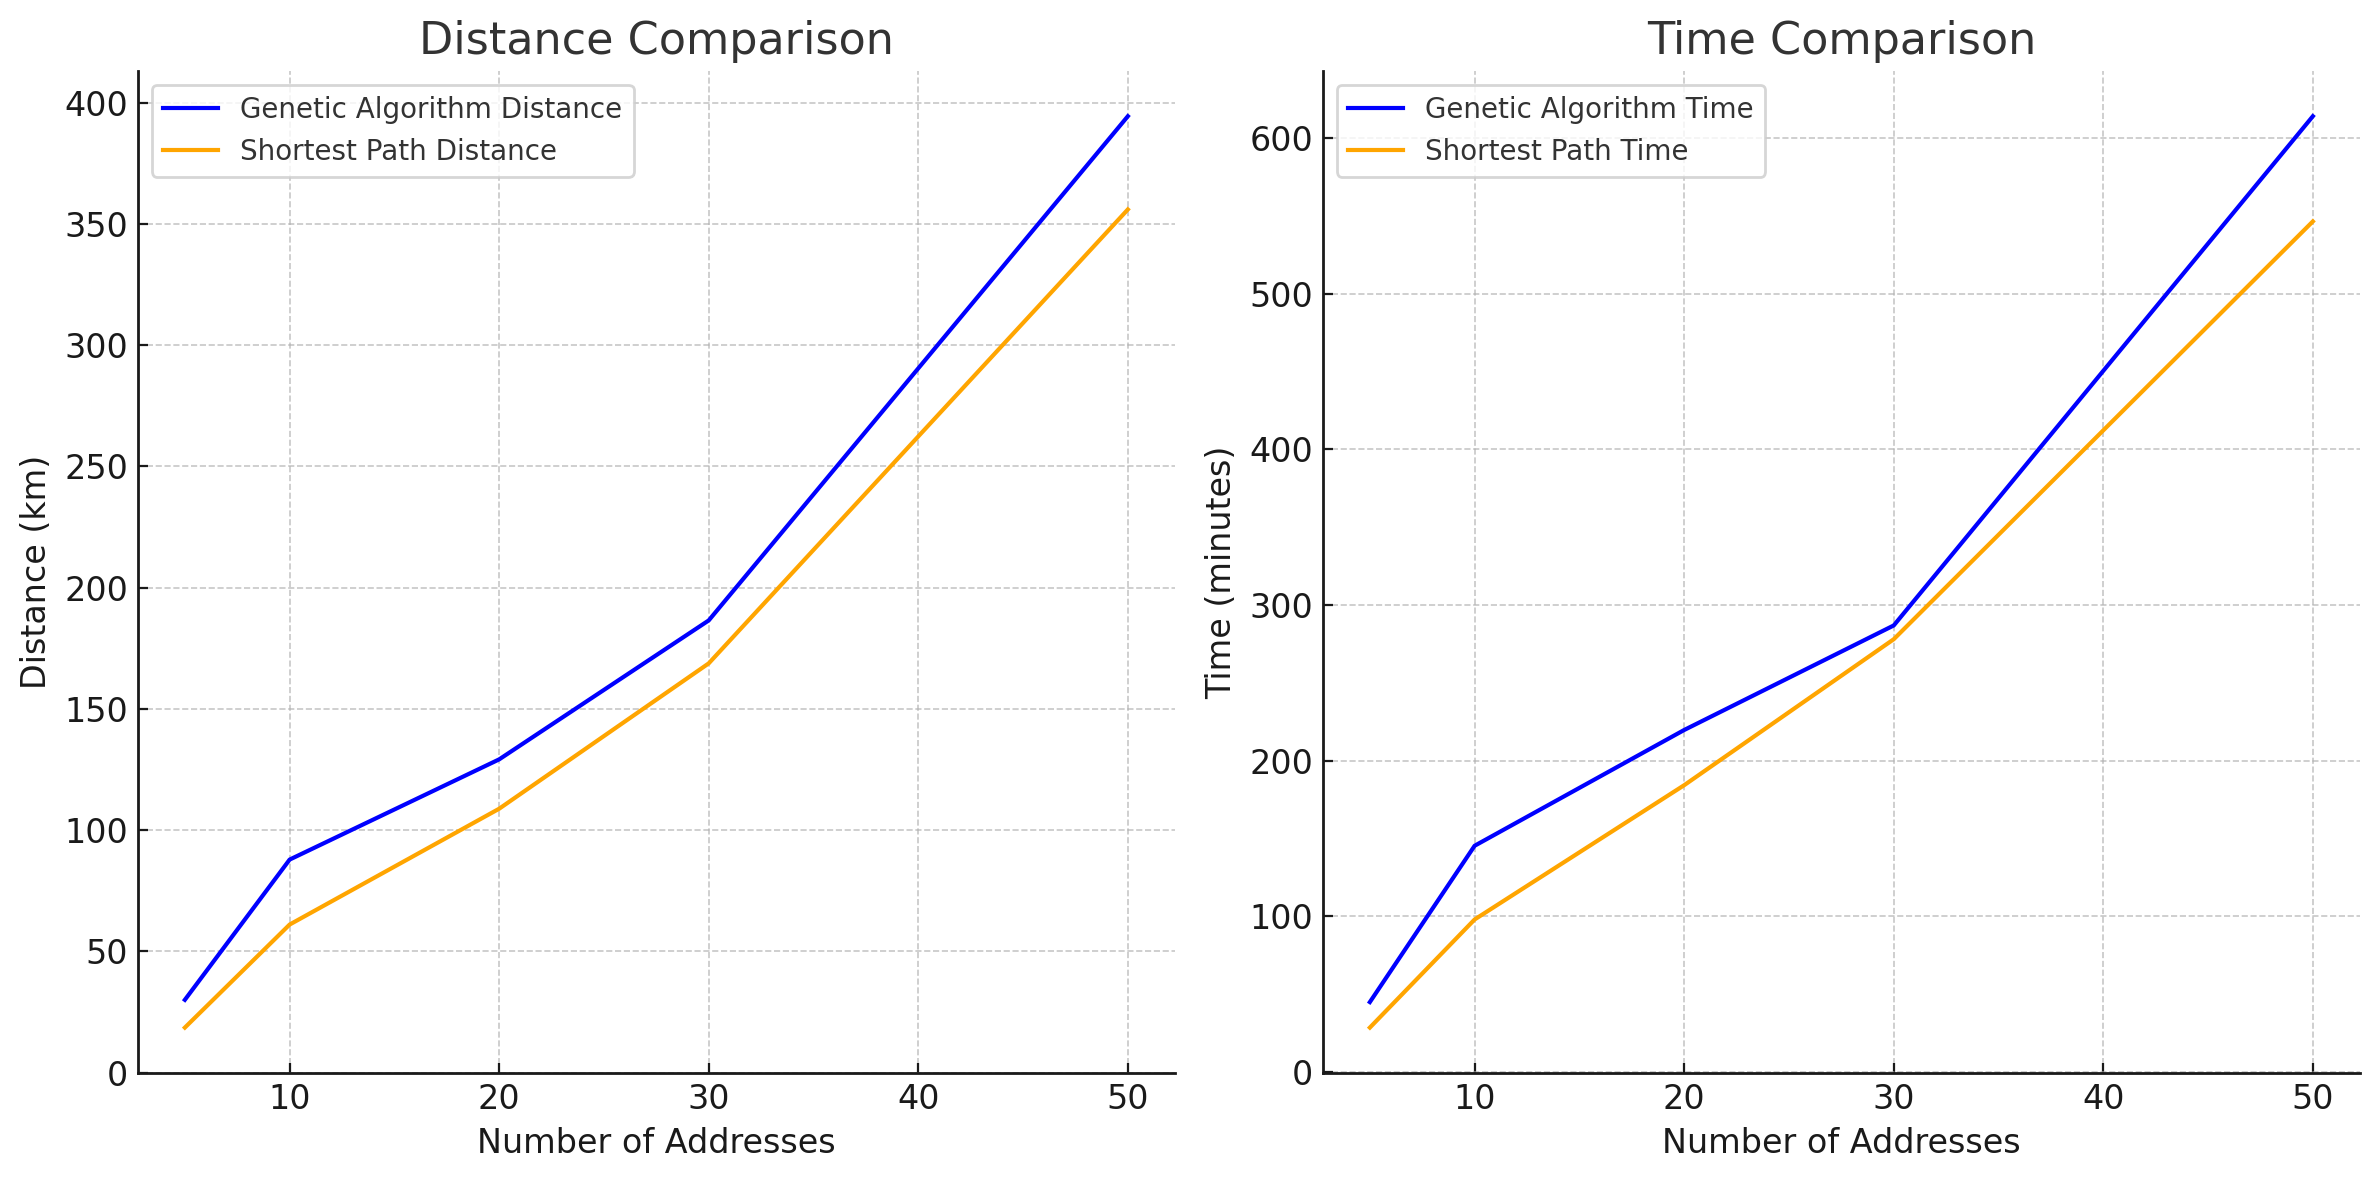

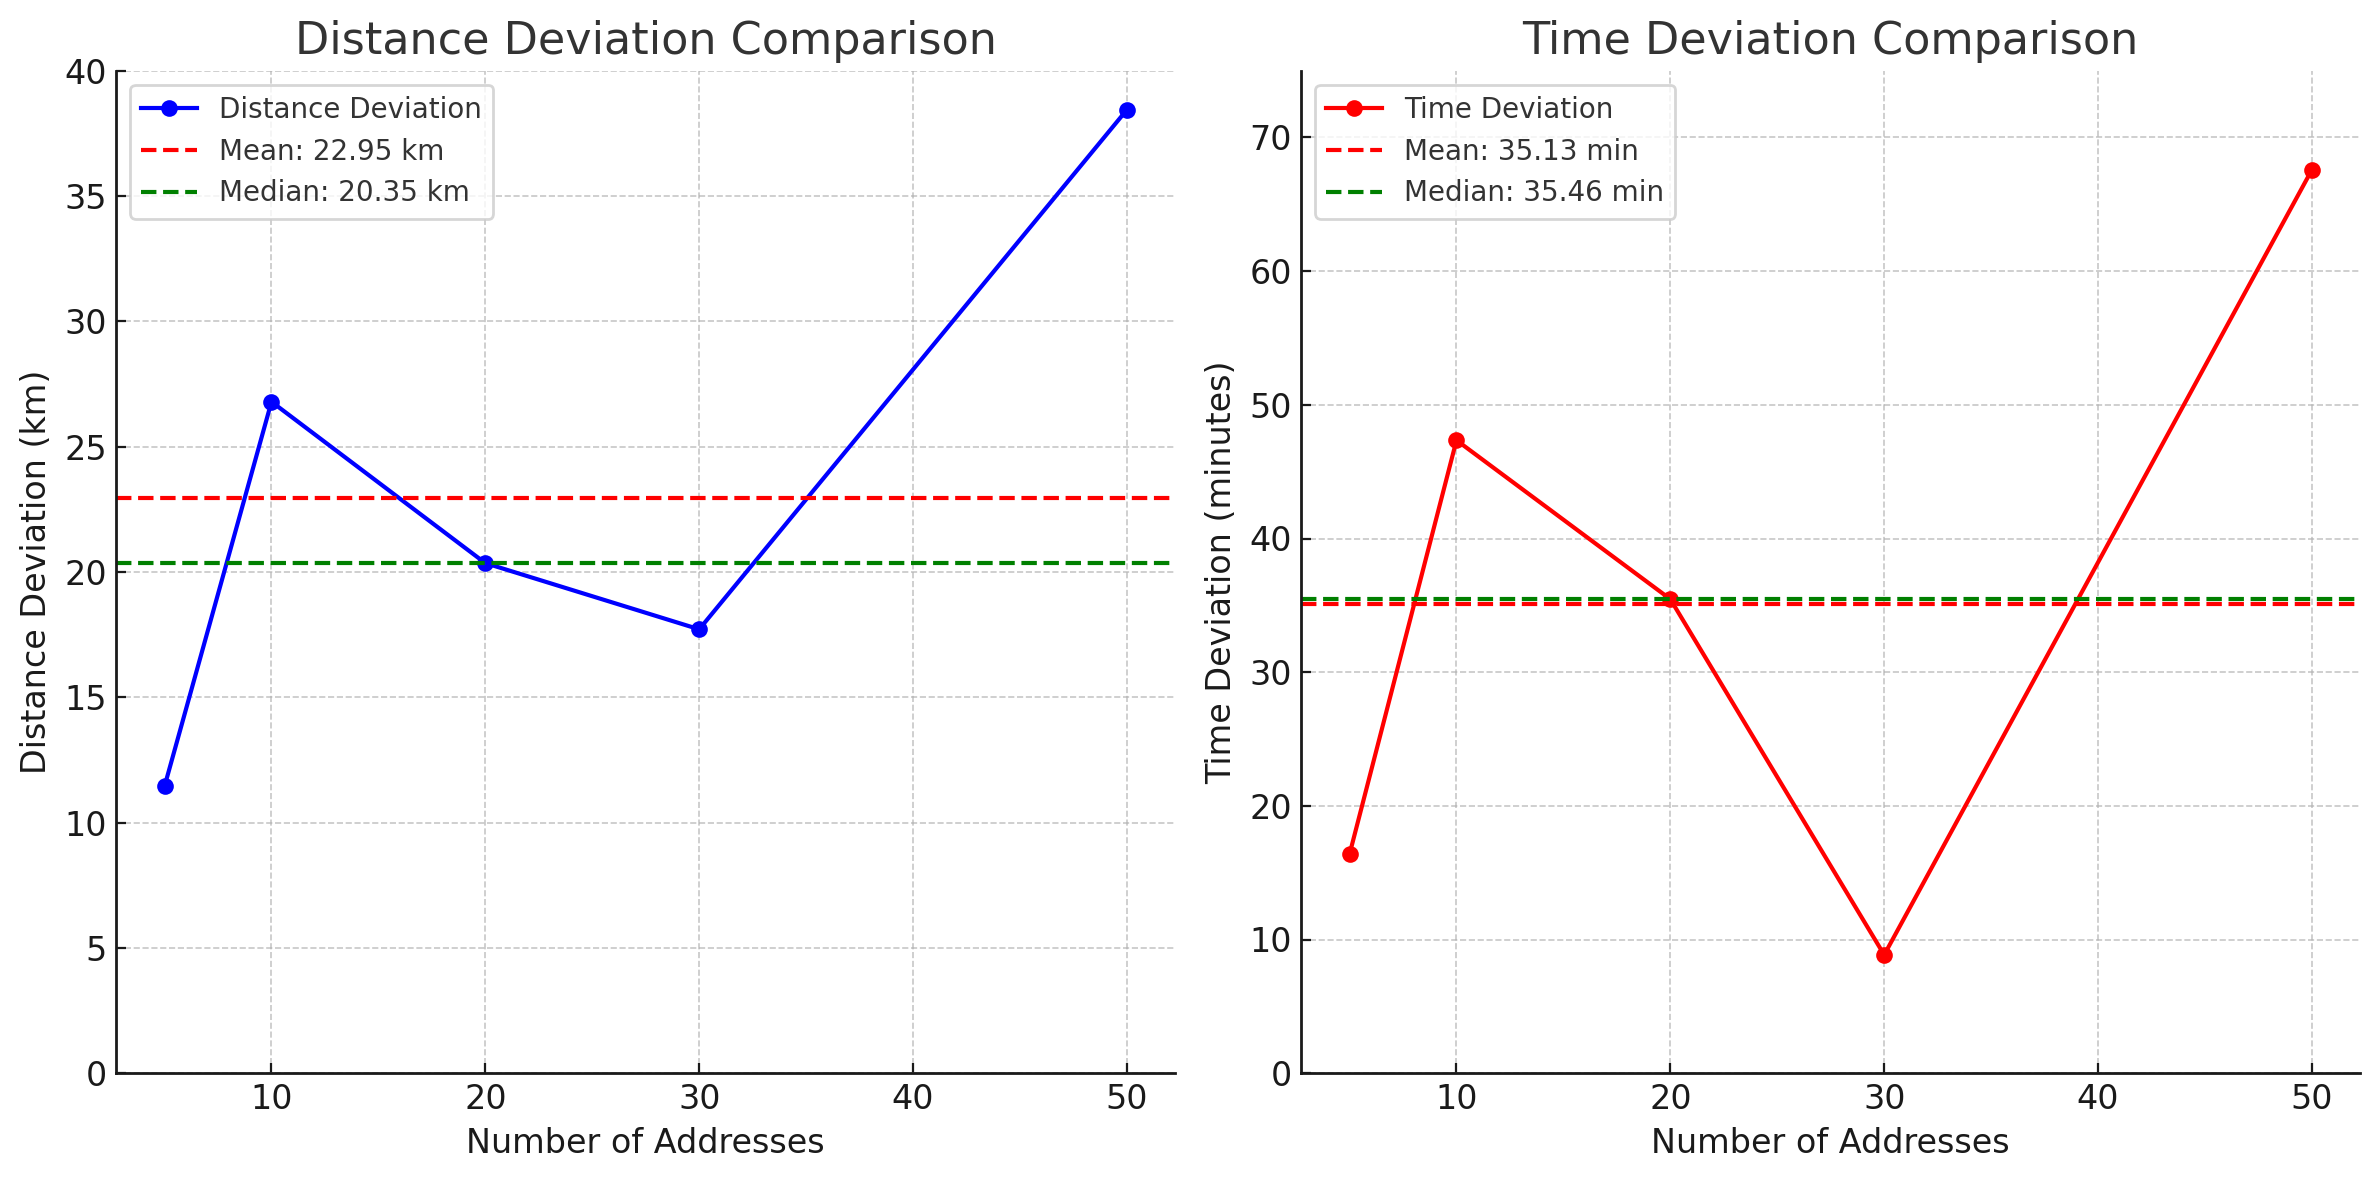

## Experimental study of convergence time (Optional)

The graph shows an increase in processing time with the number of addresses, suggesting a near-linear relationship.

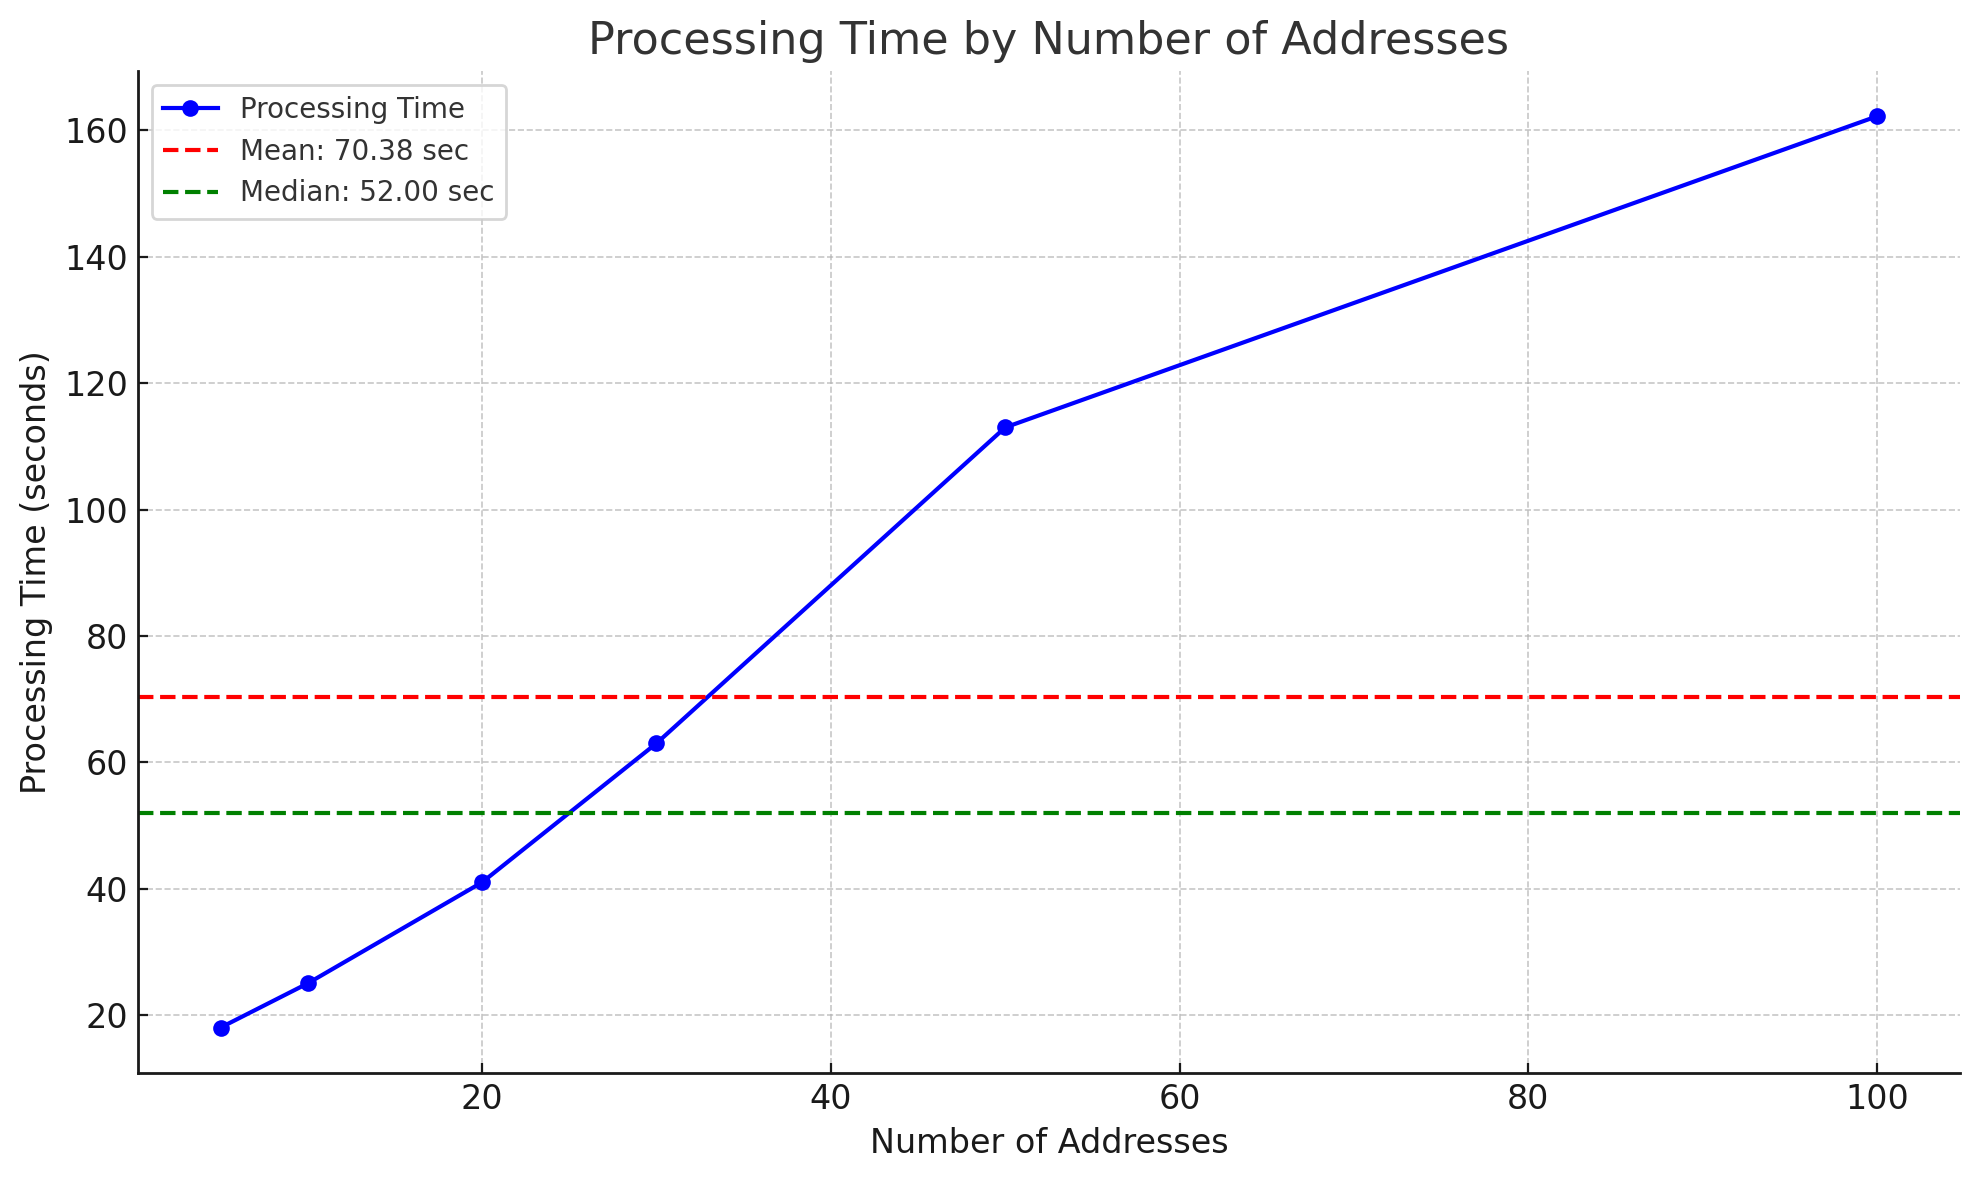

The graph illustrates delivery time across different vehicle counts, showing minimal variation around the mean (111.555 seconds) and median (110.156 seconds). Adding vehicles has a limited effect on reducing delivery time.

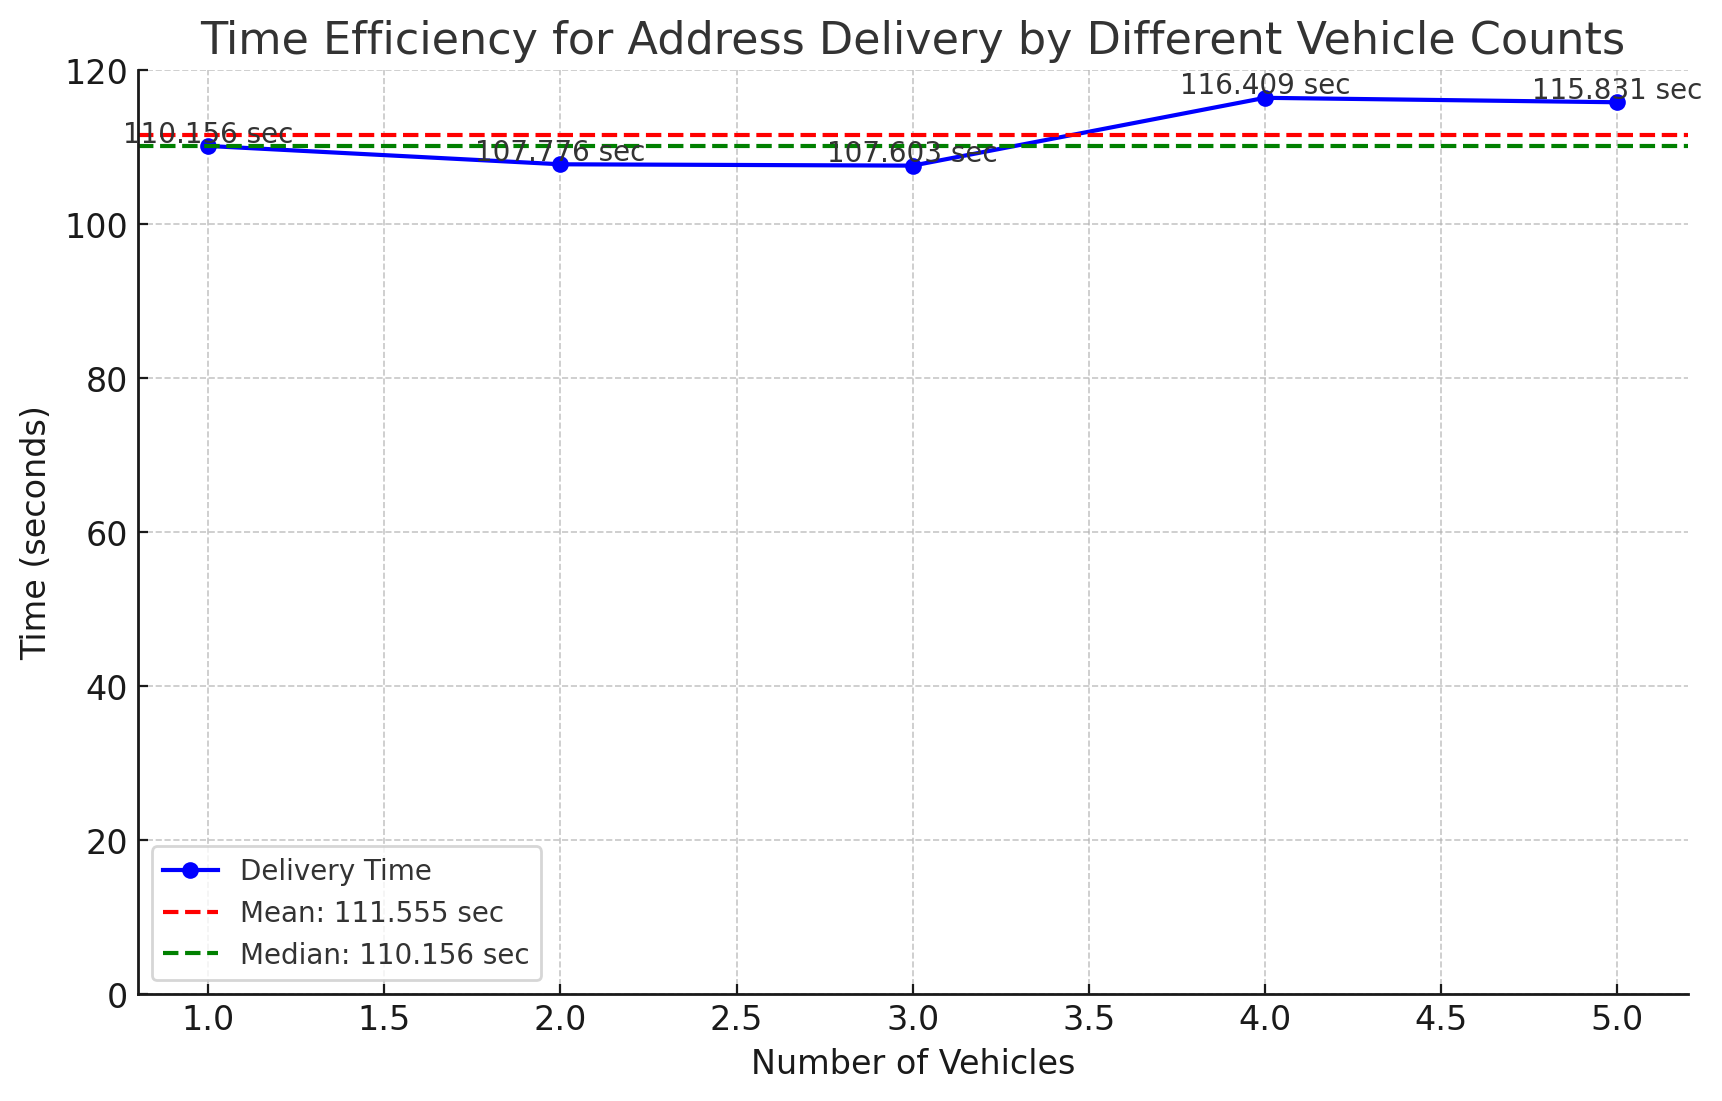

The left graph displays execution time by cxpb value, with the shortest execution time at cxpb = 0.5 (74.026 seconds), indicating optimal computational efficiency at this value. The right graph shows total travel time, also minimized at cxpb = 0.5 with a time of 244.82 minutes, suggesting this value leads to the most efficient travel schedule.

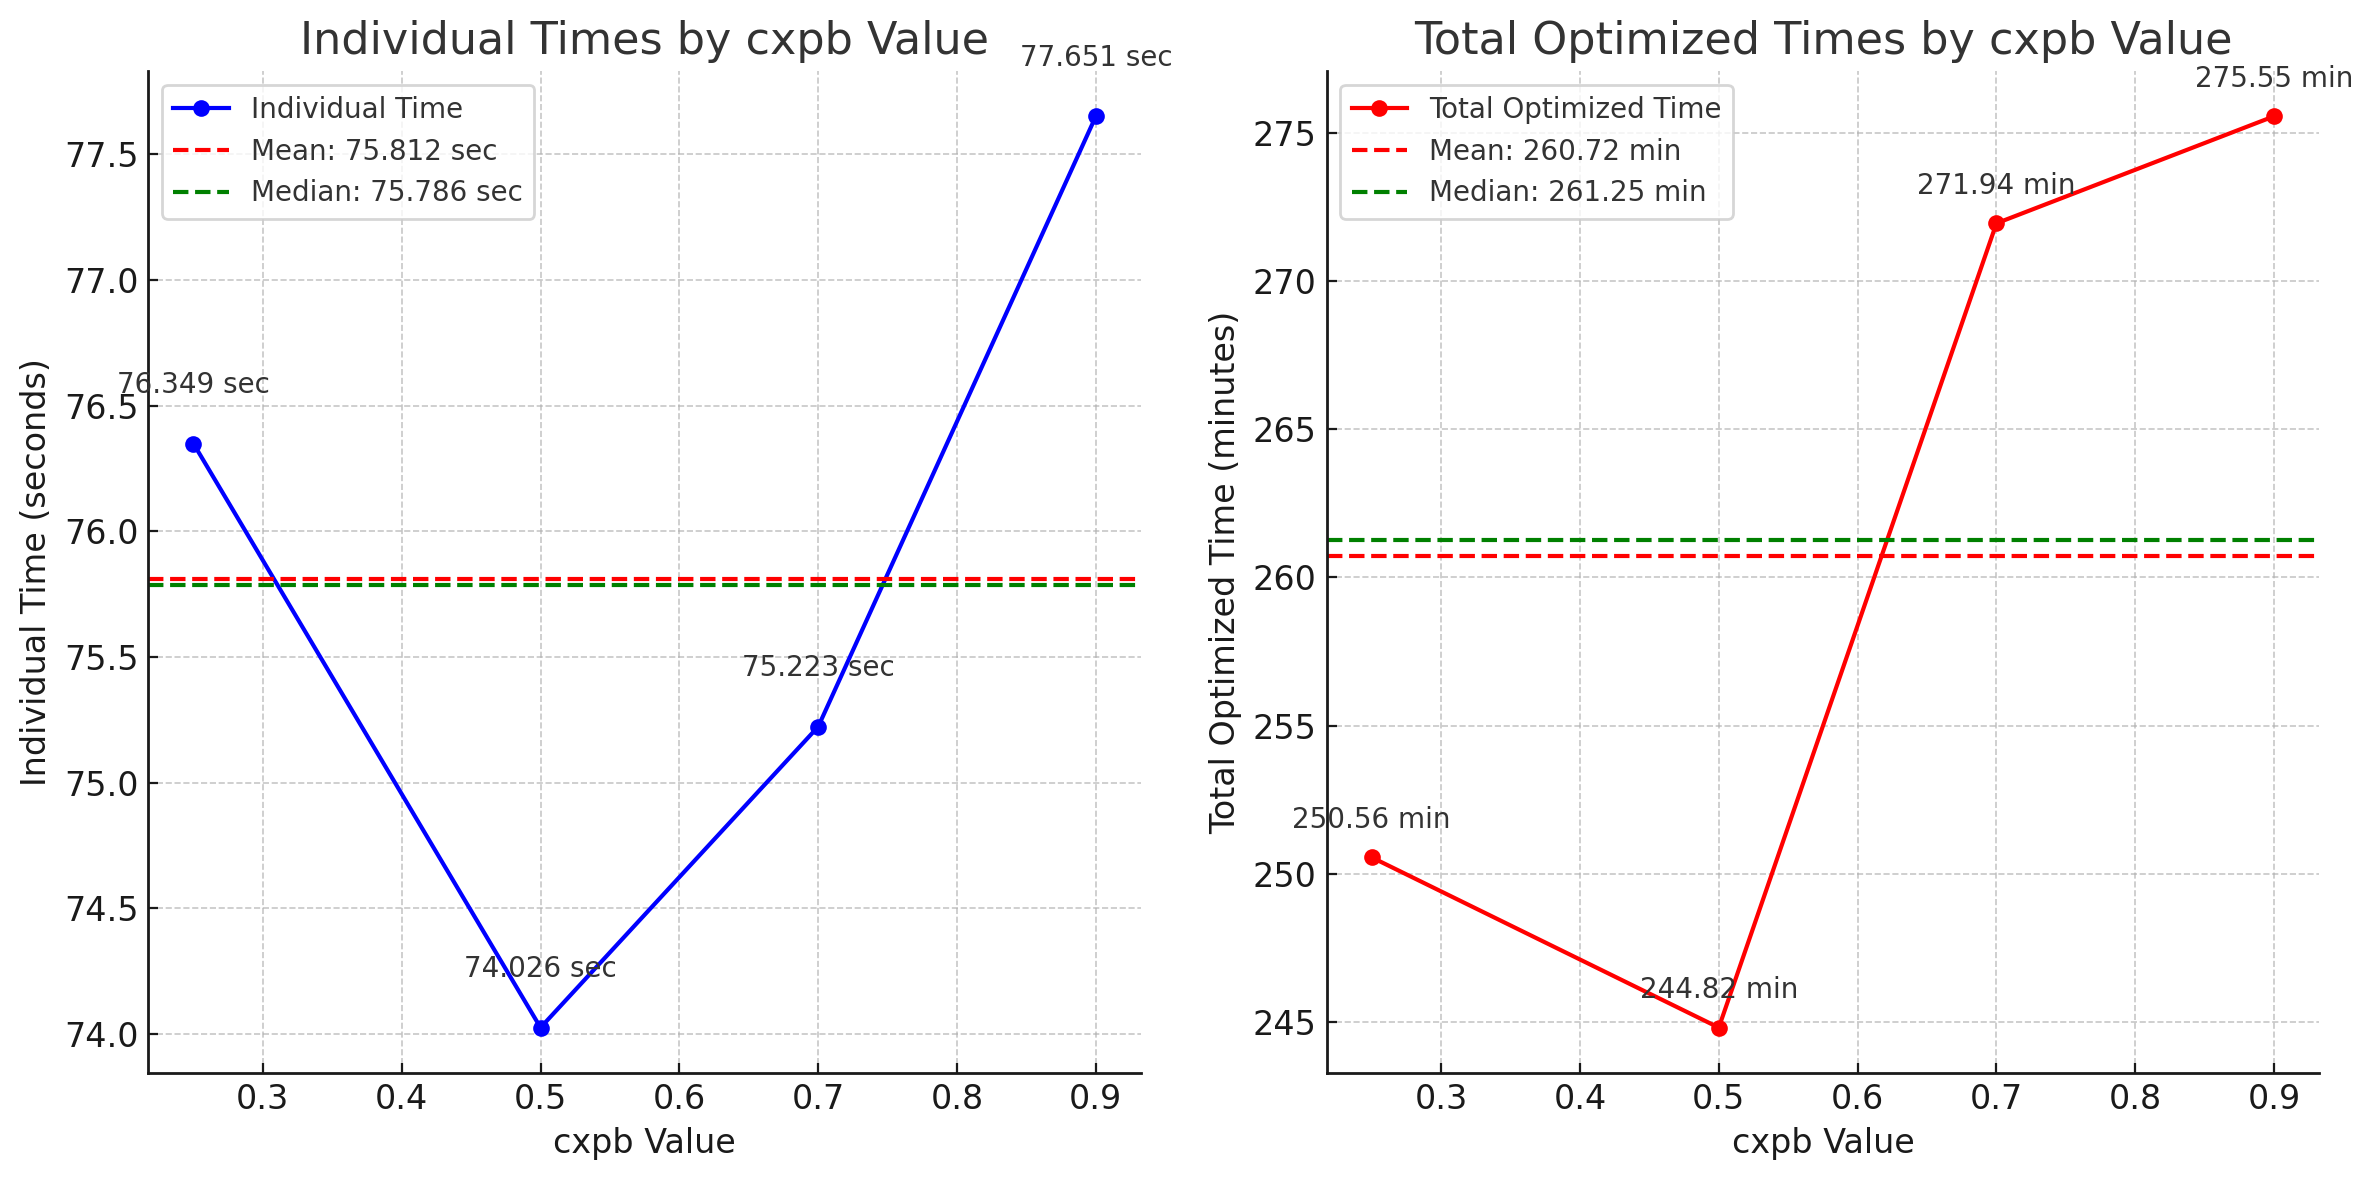

The left graph represents execution time by mutpb value, with the shortest execution time at mutpb = 0.3 (76.395 seconds), suggesting optimal efficiency at this value. The right graph illustrates total travel time, also minimized at mutpb = 0.05 with 239.78 minutes, indicating this value results in the most efficient travel duration.

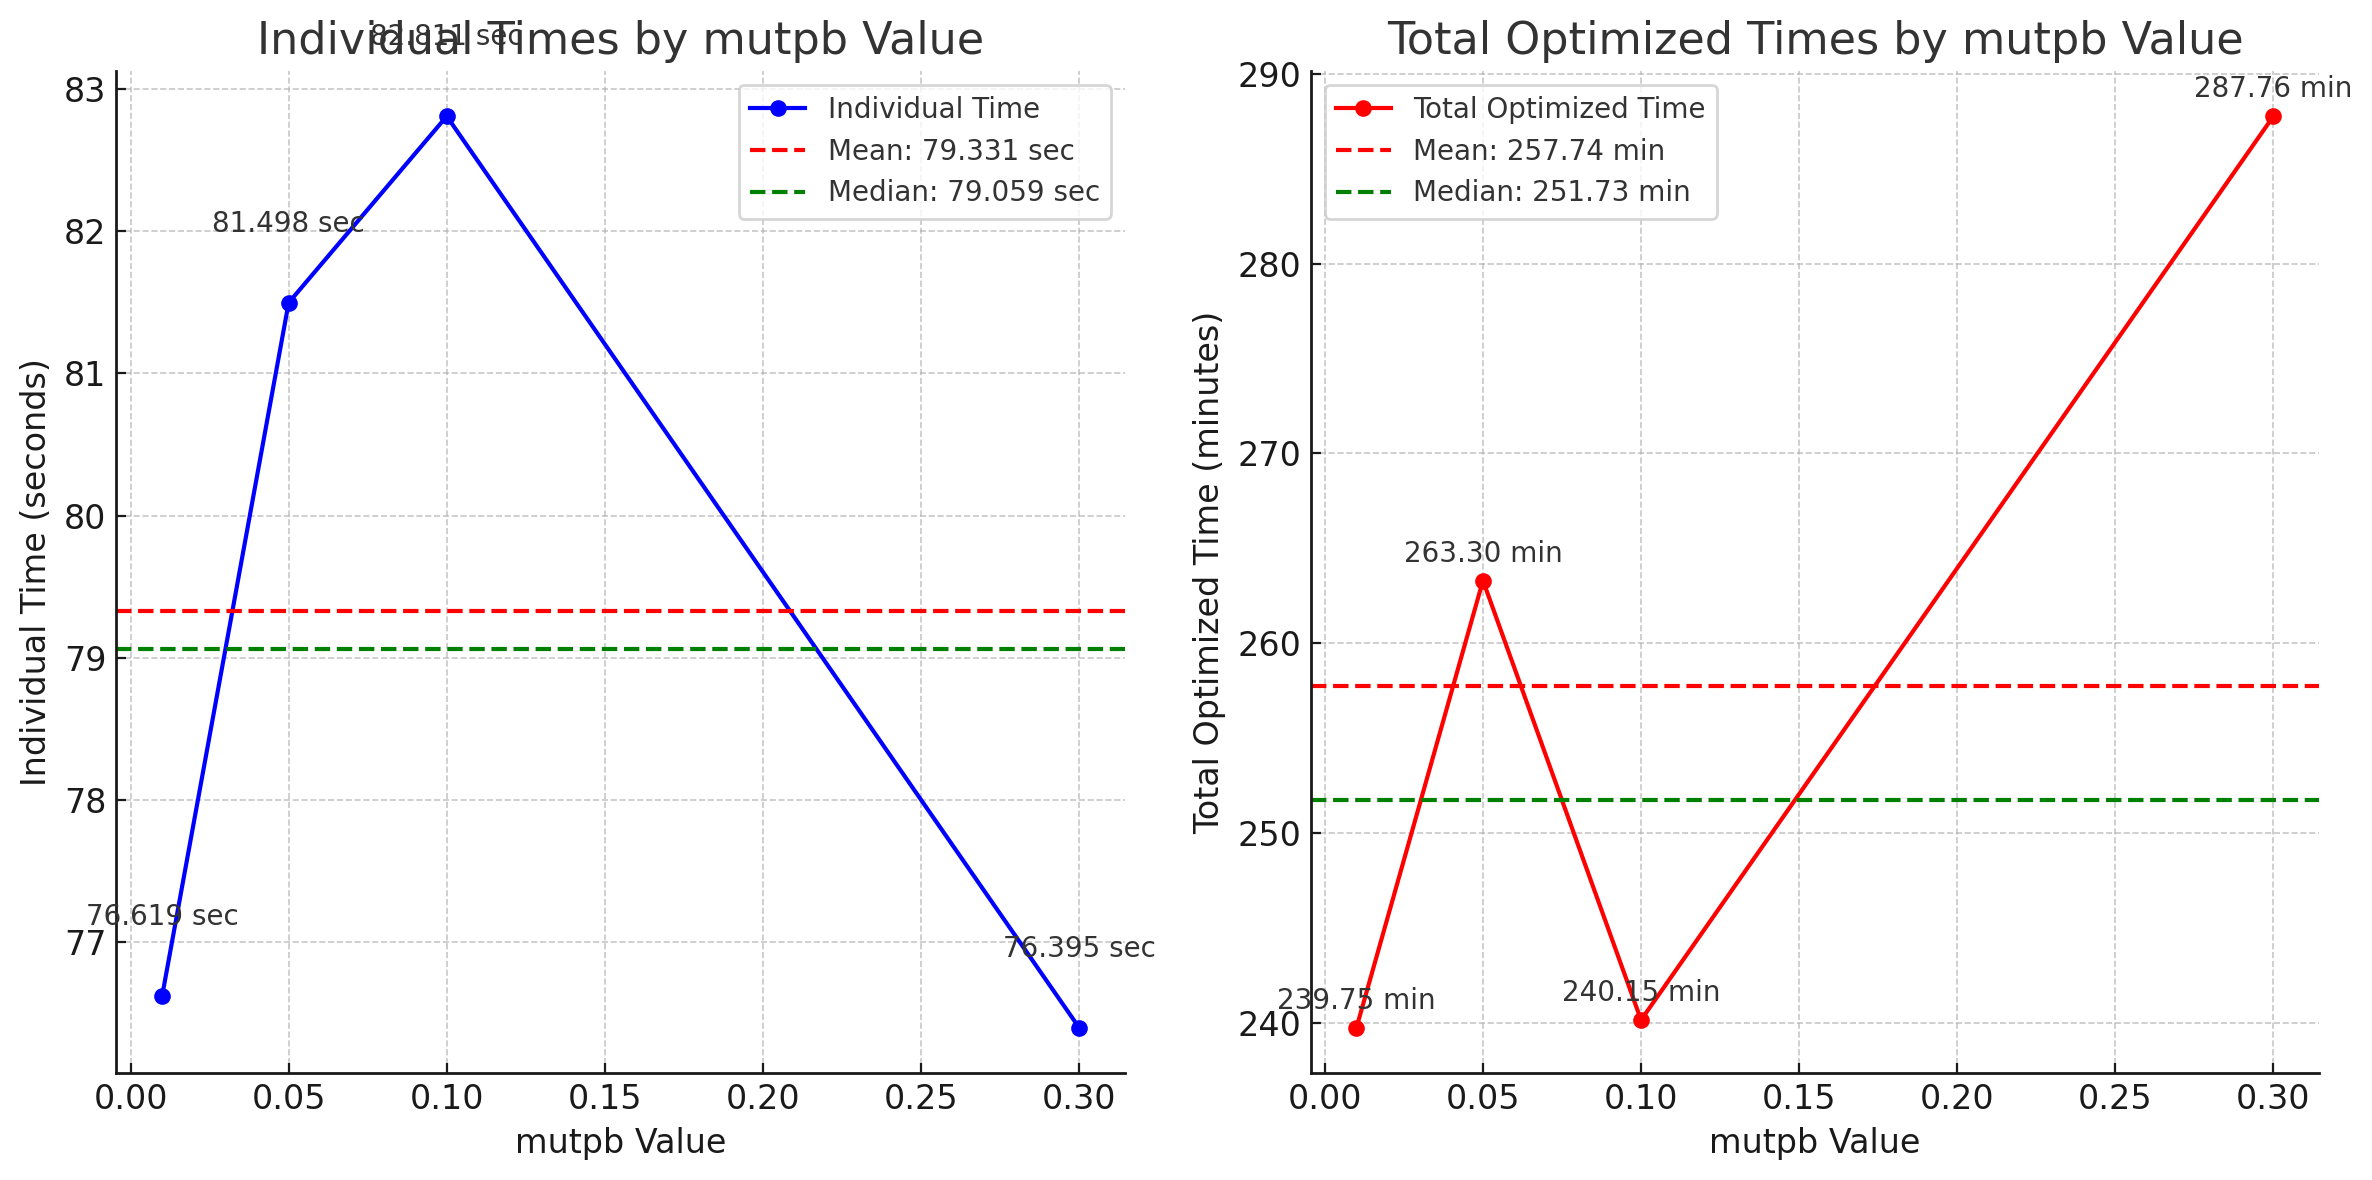

The left graph shows total optimized travel time by indp value, with the shortest travel time at indp = 0.3 (243.37 minutes), indicating maximum efficiency at this setting. The right graph displays execution time by indp value, with the lowest execution time achieved at indp = 0.3 (68 seconds), suggesting that this value is also optimal for reducing computation time.

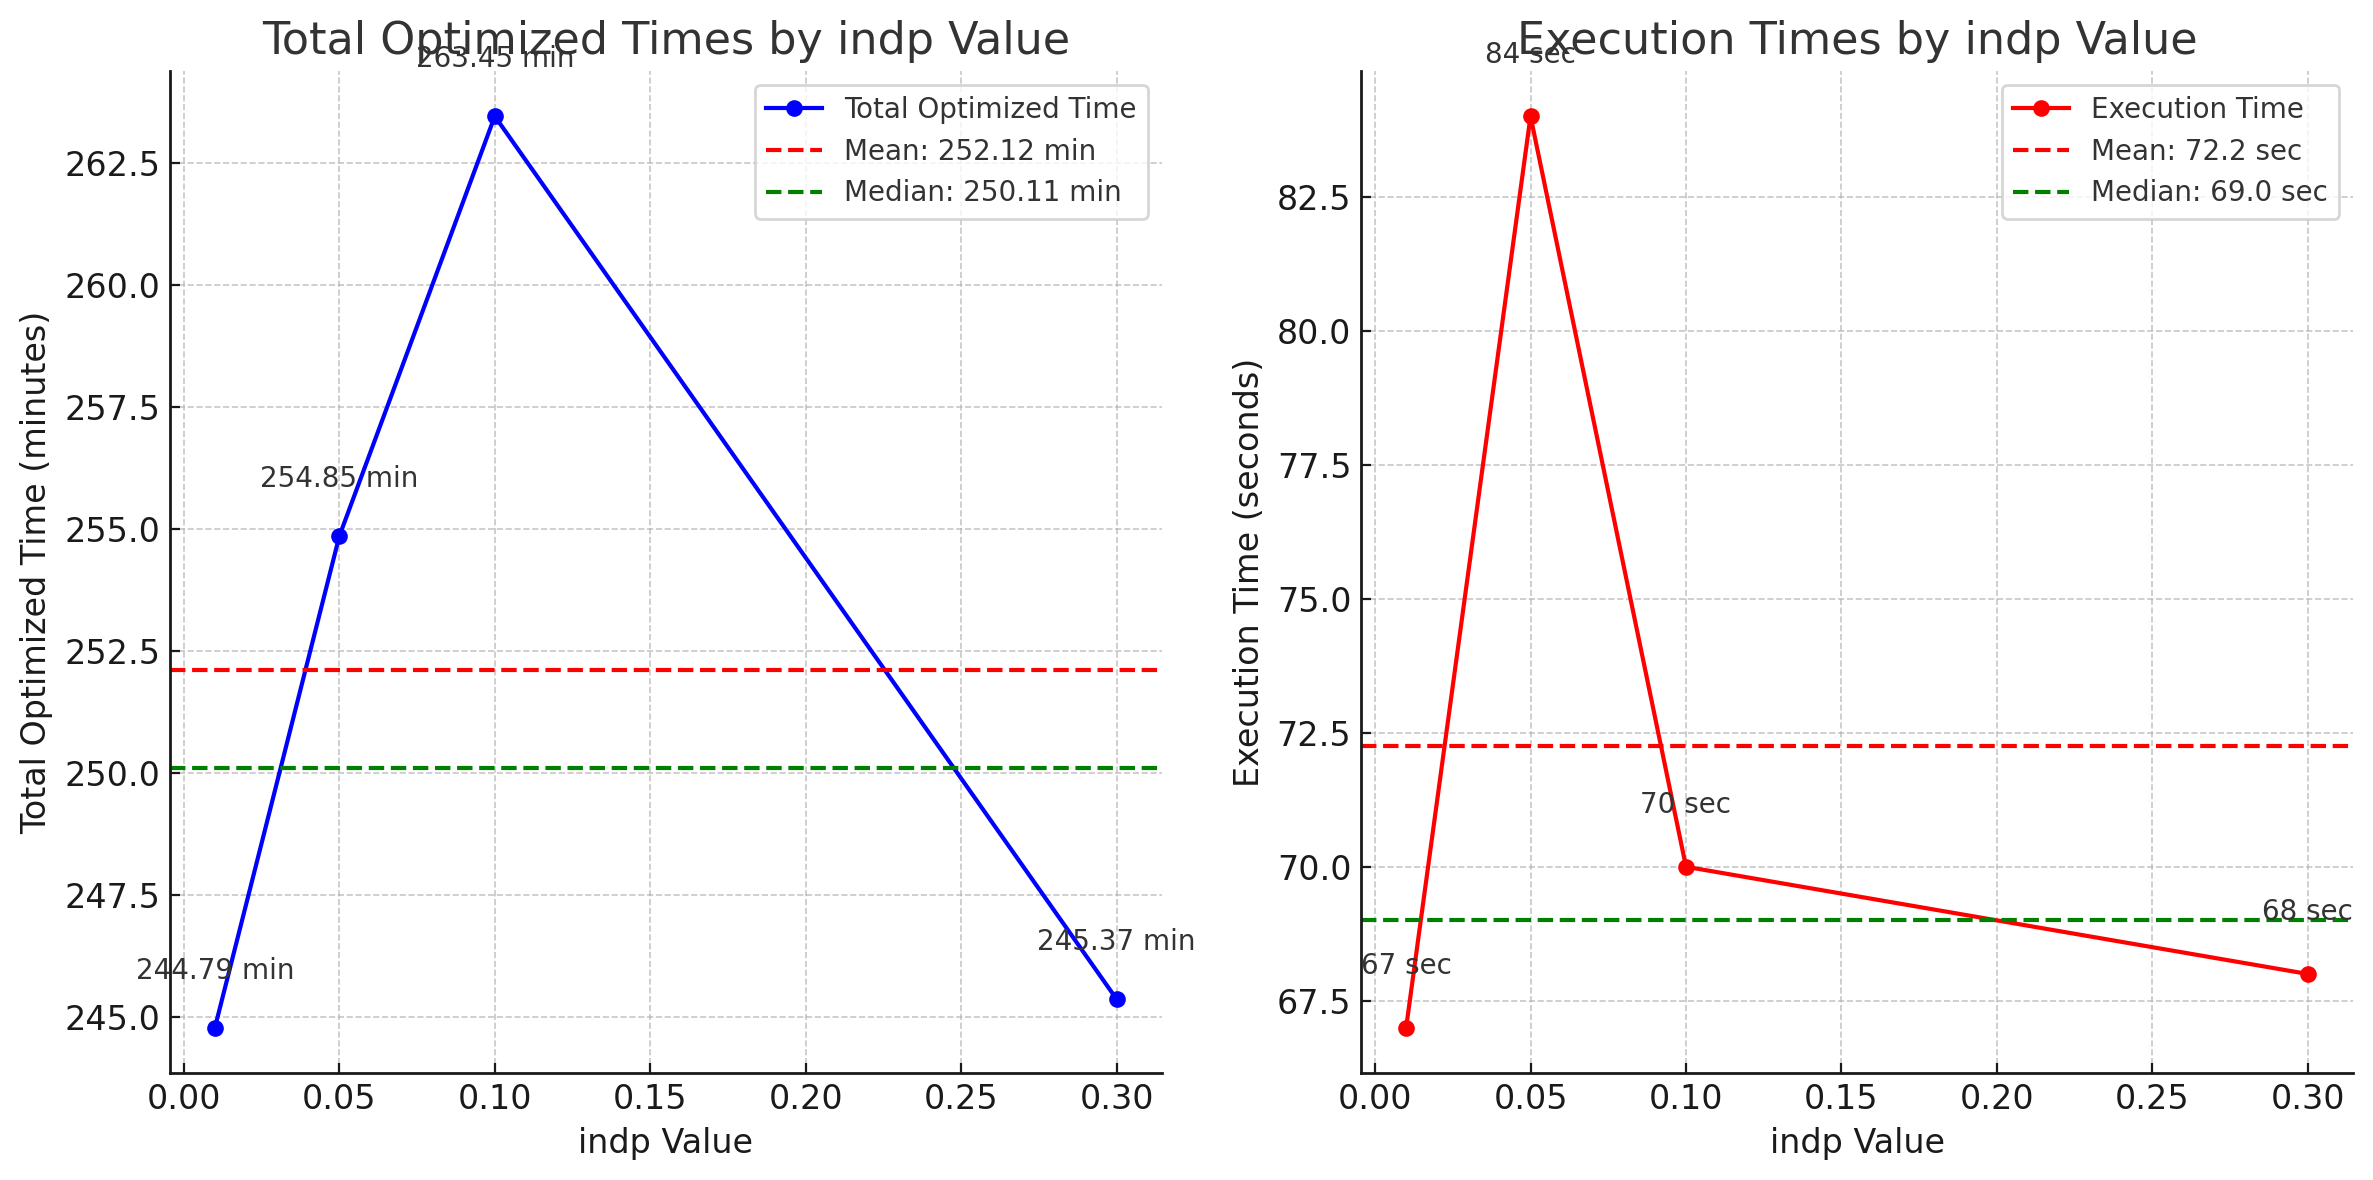